In [1]:
import ROOT, math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.stats import norm
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime

In [2]:
def PlotWithMatPlotLib(plot, Histogram, Label):
    NBin = Histogram.GetNbinsX()
    X = [0] * NBin
    Y = [0] * NBin
    YError = [0] * NBin

    for i in range(NBin):
        X[i] = Histogram.GetBinCenter(i + 1)
        Y[i] = Histogram.GetBinContent(i + 1)
        YError[i] = Histogram.GetBinError(i + 1)

    plot.errorbar(X, Y, YError, None, 'o-', label = Label)

In [3]:
def DivideByBinWidth(Histogram):
    NBin = Histogram.GetNbinsX()
    
    for i in range(NBin):
        L = Histogram.GetXaxis().GetBinLowEdge(i)
        R = Histogram.GetXaxis().GetBinUpEdge(i)
        Histogram.SetBinContent(i + 1, Histogram.GetBinContent(i + 1) / (R - L))
        Histogram.SetBinError(i + 1, Histogram.GetBinError(i + 1) / (R - L))

def Integral(Histogram):
    NBin = Histogram.GetNbinsX()

    Result = 0
    for i in range(NBin):
        L = Histogram.GetXaxis().GetBinLowEdge(i)
        R = Histogram.GetXaxis().GetBinUpEdge(i)
        Result = Result + Histogram.GetBinContent(i + 1) * (R - L)

    return Result



In [4]:
def MakeQuickPlot(OutputFileName, FileNames, ToPlot, RefCoefficients, DiffCoefficients, Rebin, Logy = False):

    figsize = (8, 6)
    
    NFile = len(FileNames)

    Files = [None] * NFile
    for iF in range(NFile):
        Files[iF] = ROOT.TFile(FileNames[iF])

    Hist = [None] * NFile
    HistDiff = None
    HistRef = None

    for iF in range(NFile):
        Hist[iF] = Files[iF].Get(ToPlot)
        Hist[iF].Scale(1 / Files[iF].Get("HCount").GetBinContent(1))
        Hist[iF].Rebin(Rebin)
        DivideByBinWidth(Hist[iF])

        if iF == 0:
            HistRef = Hist[iF].Clone("HistRef")
            HistRef.Scale(RefCoefficients[iF])
            HistDiff = Hist[iF].Clone("HistDiff")
            HistDiff.Scale(DiffCoefficients[iF])
        else:
            HistRef.Add(Hist[iF], RefCoefficients[iF])
            HistDiff.Add(Hist[iF], DiffCoefficients[iF])

    with PdfPages(OutputFileName) as pdf:

        figure = plt.figure(figsize = figsize)
        figure.clf()
        figure.text(0.5, 0.5, OutputFileName, transform = figure.transFigure, size = 24, ha = "center")
        pdf.savefig(dpi = 150, transparent = False)
        plt.close()
        
        for iF in range(NFile):
            figure = plt.figure(figsize = figsize)
            PlotWithMatPlotLib(plt, Hist[iF], FileNames[iF])
            plt.xlabel(Hist[iF].GetXaxis().GetTitle())
            plt.ylabel(Hist[iF].GetYaxis().GetTitle())
            plt.legend()
            if Logy == True:
                plt.gca().set_yscale('log')
            pdf.savefig(dpi = 150, transparent = False)
            plt.close()
        
        figure = plt.figure(figsize = figsize)
        for iF in range(NFile):
            PlotWithMatPlotLib(plt, Hist[iF], f"{FileNames[iF]} ({Integral(Hist[iF])}) [{DiffCoefficients[iF]}]")
        PlotWithMatPlotLib(plt, HistRef, f"Reference ({Integral(HistRef)})")
        PlotWithMatPlotLib(plt, HistDiff, f"Combined ({Integral(HistDiff)})")
        plt.xlabel(HistRef.GetXaxis().GetTitle())
        plt.ylabel(HistRef.GetYaxis().GetTitle())
        plt.legend()
        if Logy == True:
            plt.gca().set_yscale('log')
        pdf.savefig(dpi = 150, transparent = False)
        plt.close()

        figure = plt.figure(figsize = figsize)
        PlotWithMatPlotLib(plt, HistRef, "Reference")
        PlotWithMatPlotLib(plt, HistDiff, "Combined")
        plt.xlabel(HistRef.GetXaxis().GetTitle())
        plt.ylabel(HistRef.GetYaxis().GetTitle())
        plt.legend()
        if Logy == True:
            plt.gca().set_yscale('log')
        plt.title(OutputFileName)
        pdf.savefig(dpi = 150, transparent = False)
        plt.show()
        plt.close()

        # print(f"Reference integral = {Integral(HistRef)}, Combined integral = {Integral(HistDiff)}")

        HistDiff.Divide(HistRef)
        
        figure = plt.figure(figsize = figsize)
        PlotWithMatPlotLib(plt, HistDiff, "Ratio")
        plt.xlabel(HistRef.GetXaxis().GetTitle())
        plt.ylabel(HistRef.GetYaxis().GetTitle())
        plt.legend()
        plt.gca().set_yscale('linear')
        plt.title(OutputFileName)
        pdf.savefig(dpi = 150, transparent = False)
        # plt.show()
        plt.close()
        
        figure = plt.figure(figsize = figsize)
        figure.clf()
        figure.text(0.5, 0.5, datetime.now().strftime("Generated on %Y %b %d, %H:%M:%S"), transform = figure.transFigure, size = 24, ha = "center")
        pdf.savefig(dpi = 150, transparent = False)
        plt.close()
    
    for F in Files:
        F.Close()

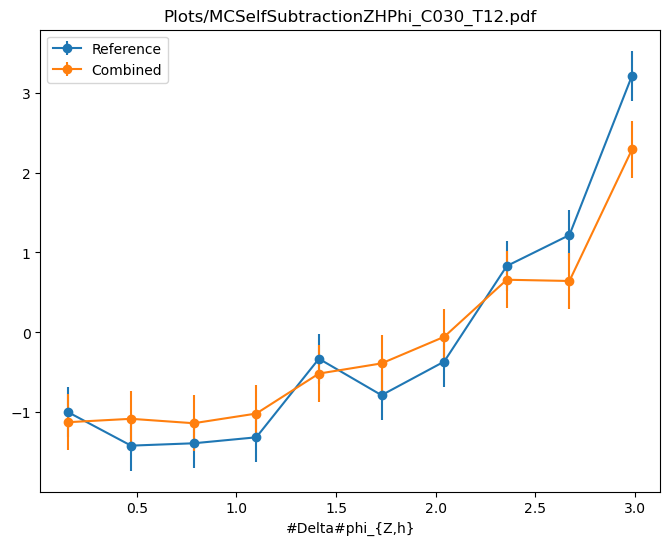

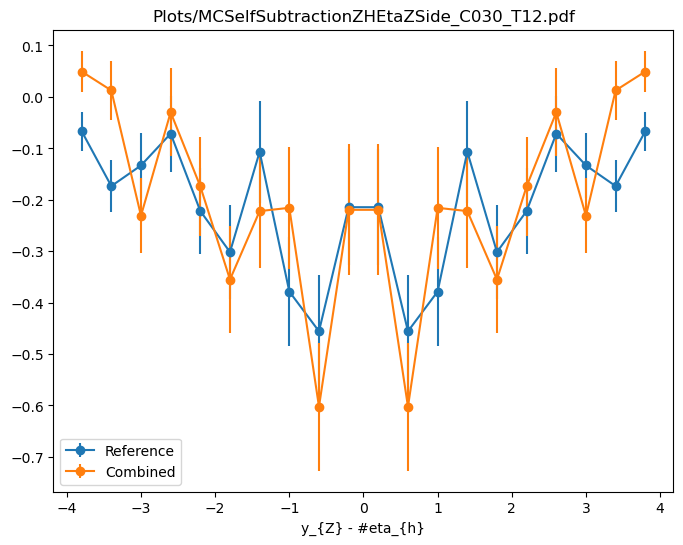

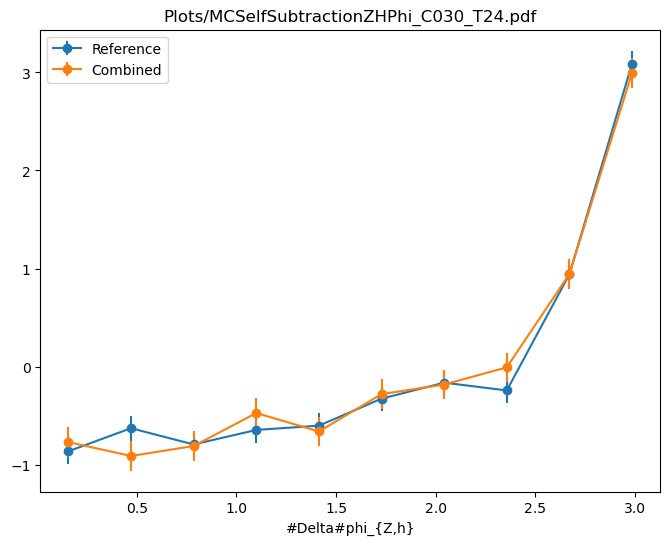

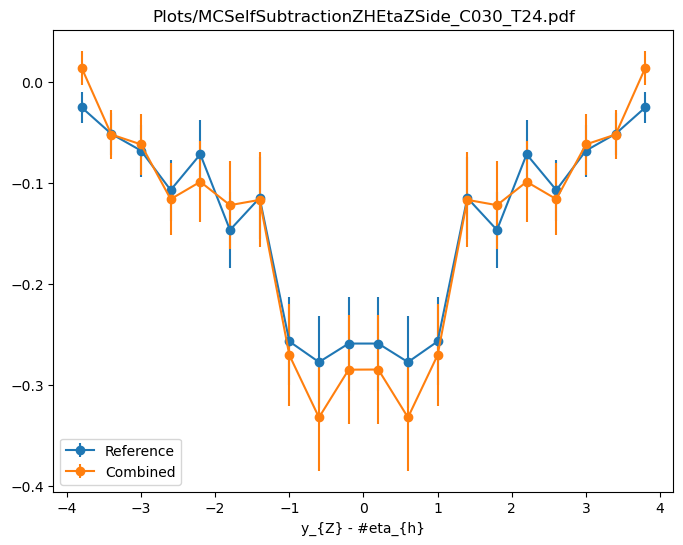

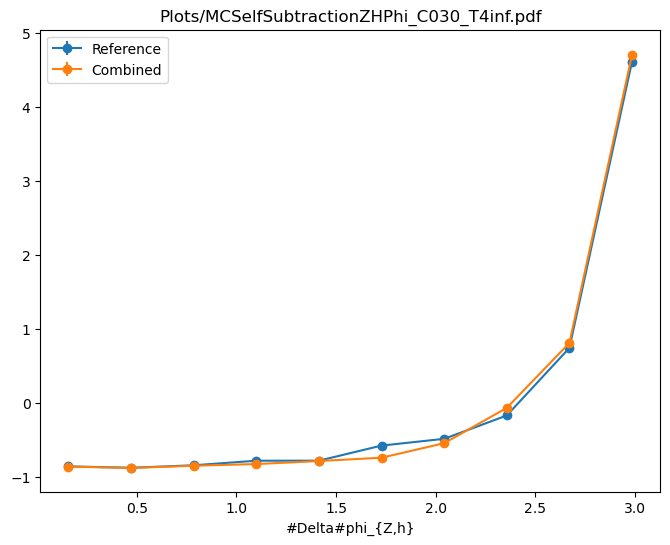

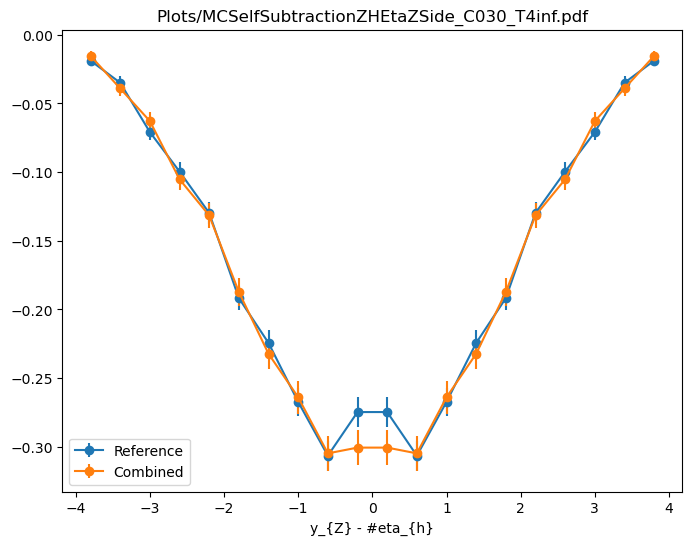

In [5]:
# MC self mixing check for Z-hadron

for T in ["12", "24", "4inf"]:
    for P in ["ZHPhi", "ZHEtaZSide"]:
        MakeQuickPlot(f"Plots/MCSelfSubtraction{P}_C030_T{T}.pdf",
            [f"PbPbMCxPbPbMC_Centrality030_T{T}.root",
                 f"PbPbMCxPbPbMC_Centrality030_T{T}_Different.root",
                 f"PbPbMCxPbPbMC_Centrality030_Reco{T}.root",
                 f"PbPbMCxPbPbMC_Centrality030_Reco{T}_Different.root"],
            f"H{P}",
            [1, -1, 0, 0],
            [0, 0, 1, -1],
            12 if "Phi" in P else 6)

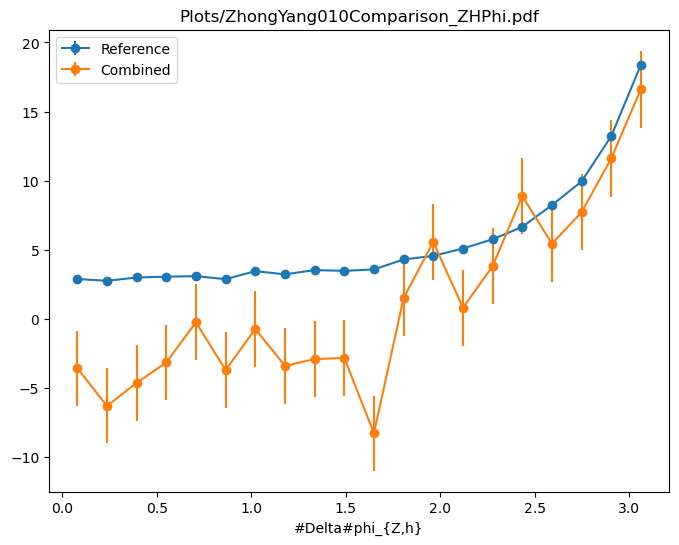

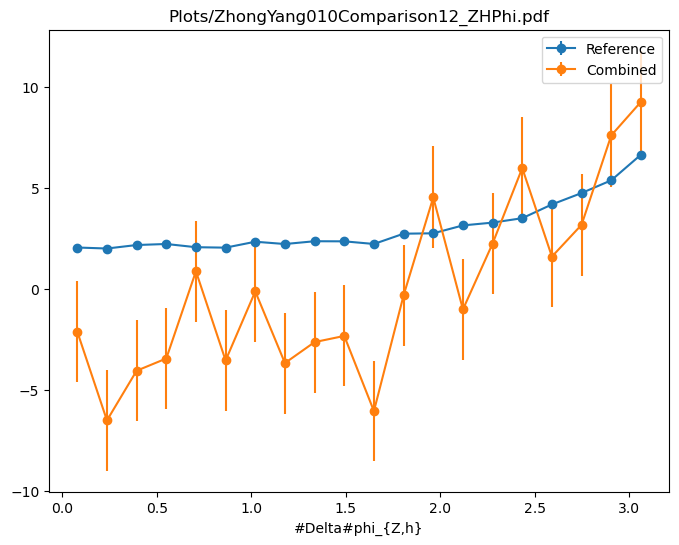

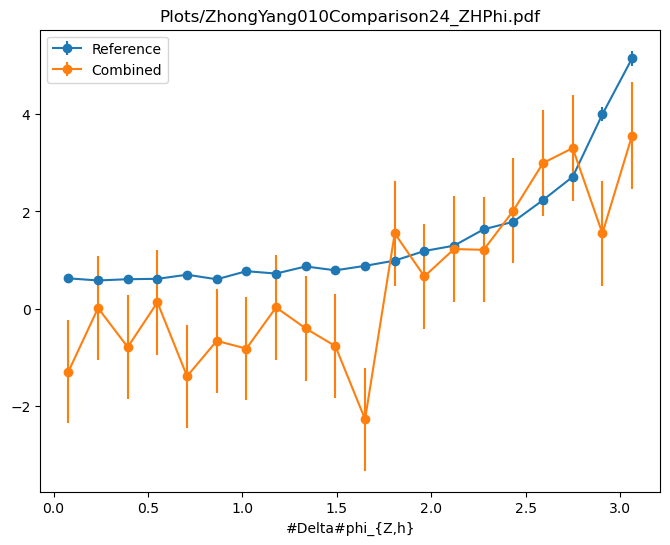

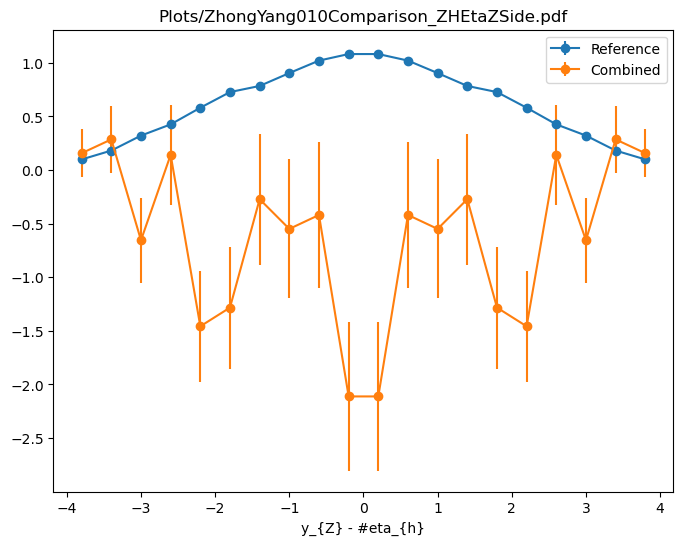

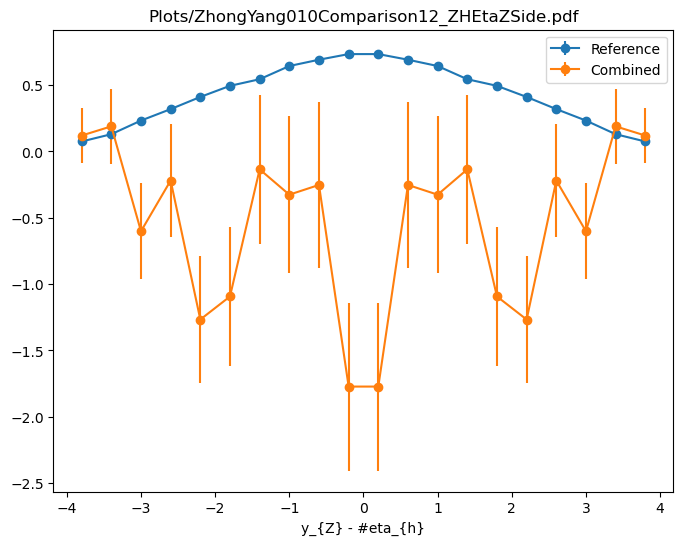

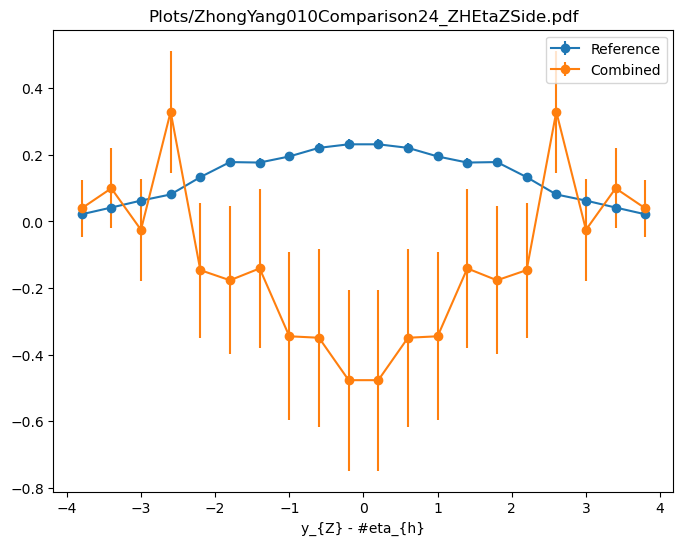

In [6]:
# Data 0-10% results

for P in ["ZHPhi", "ZHEtaZSide"]:
    for T in ["", "12", "24"]:
        MakeQuickPlot(f"Plots/ZhongYang010Comparison{T}_{P}.pdf",
            [f"PPDataxPPData_Reco{T}.root",
             f"PbPbDataxPbPbData_Centrality010_Reco{T}.root",
             f"PbPbDataxMinBiasData_Centrality010_Reco{T}.root"],
            f"H{P}",
            [1, 0, 0],
            [0, 1, -1],
            6)


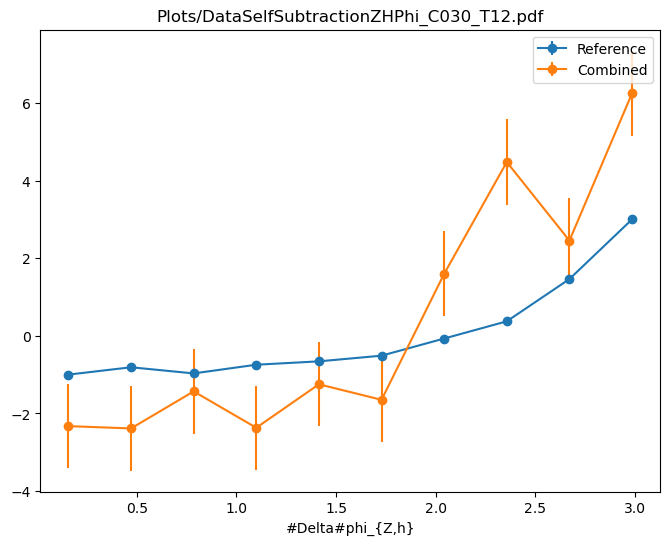

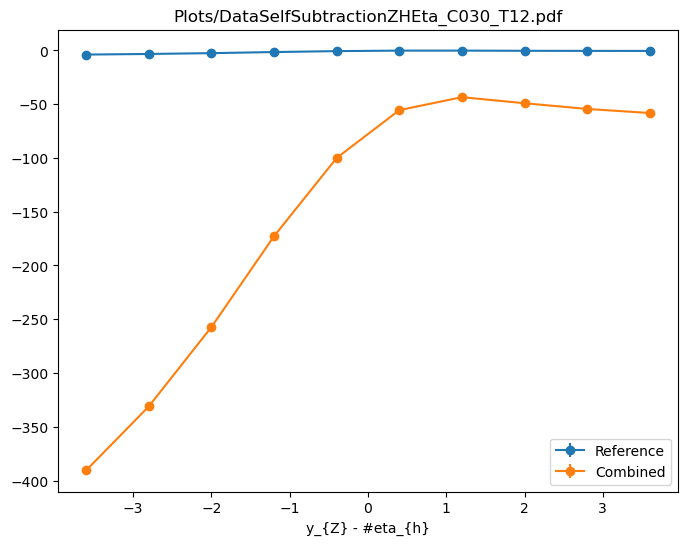

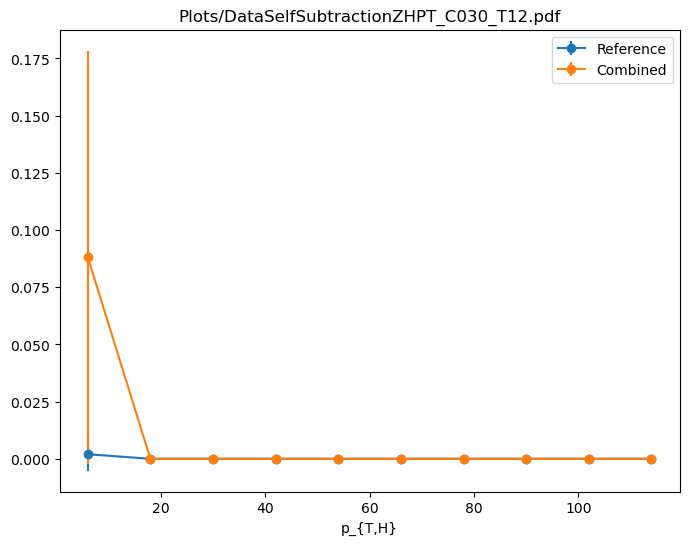

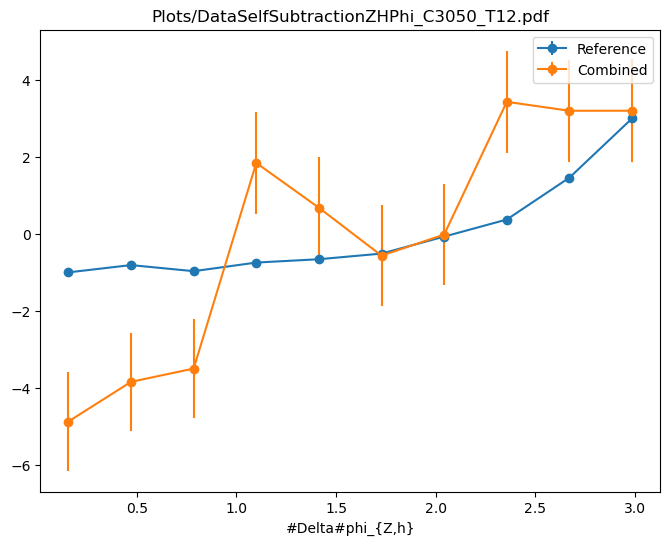

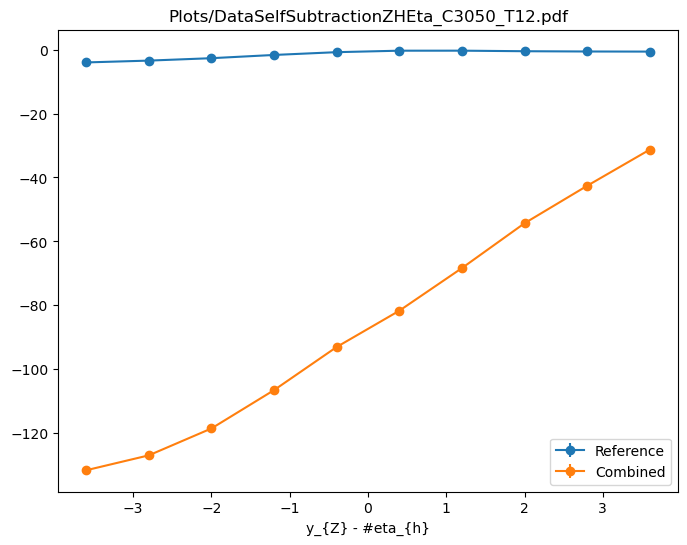

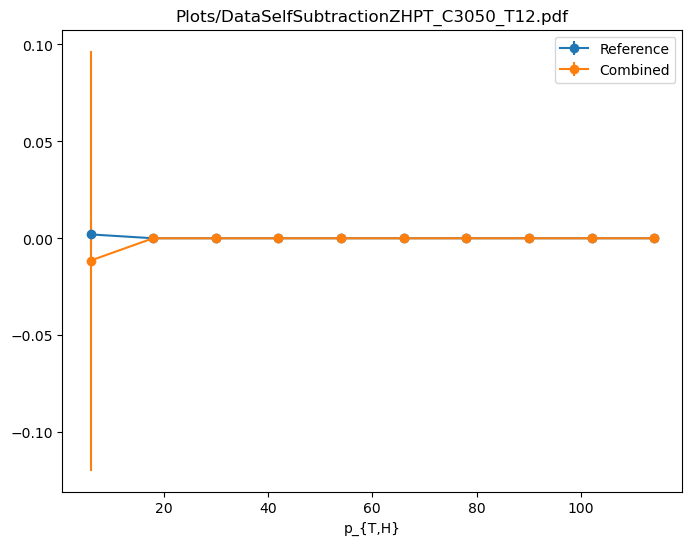

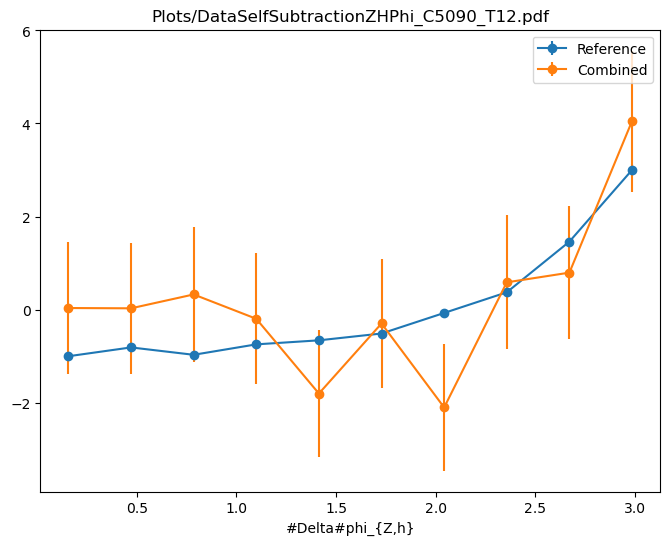

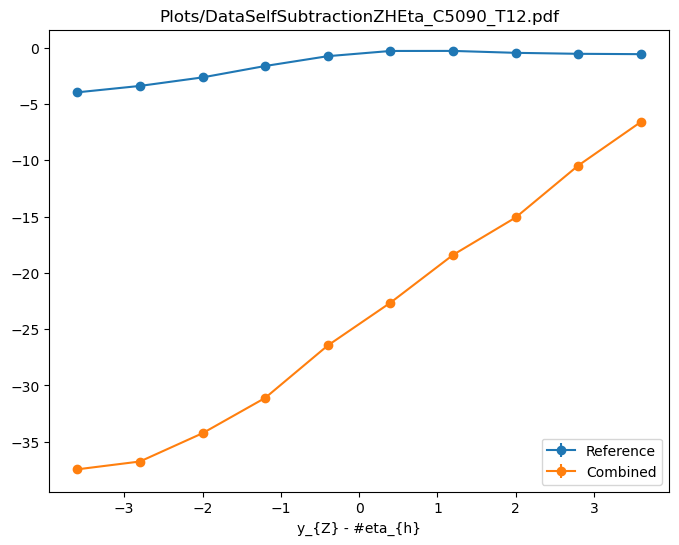

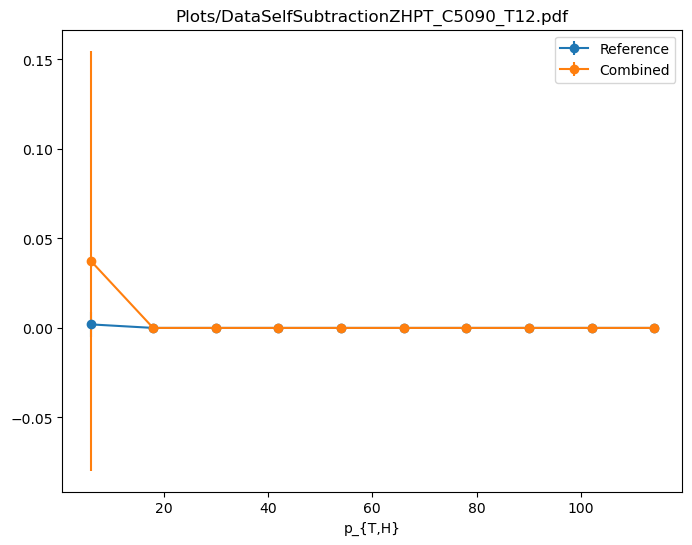

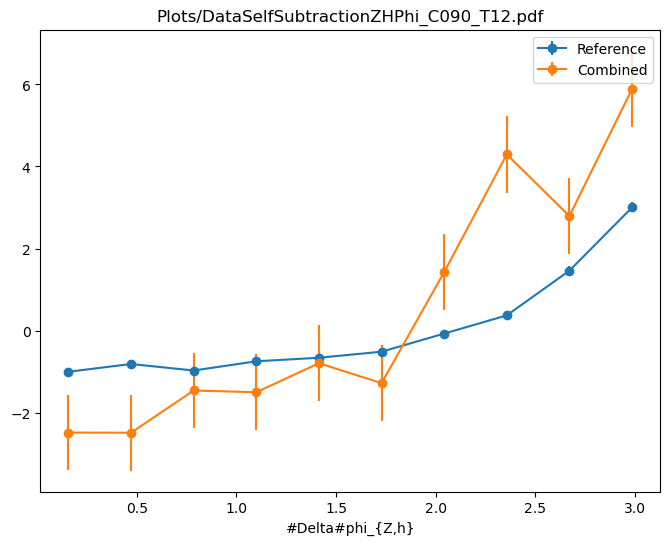

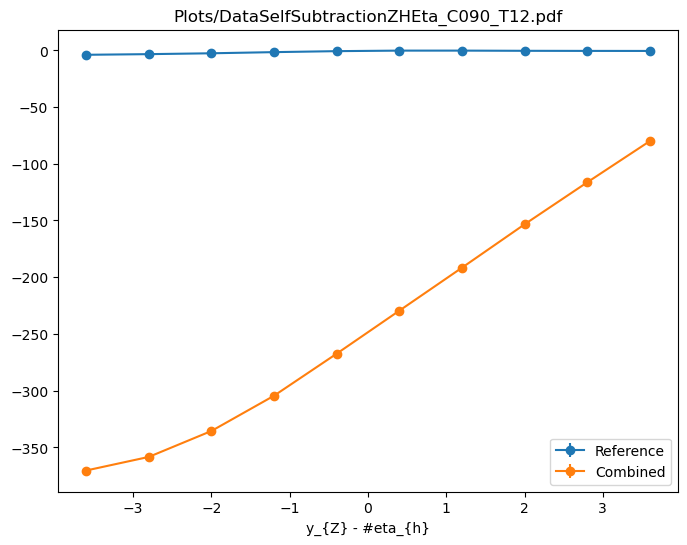

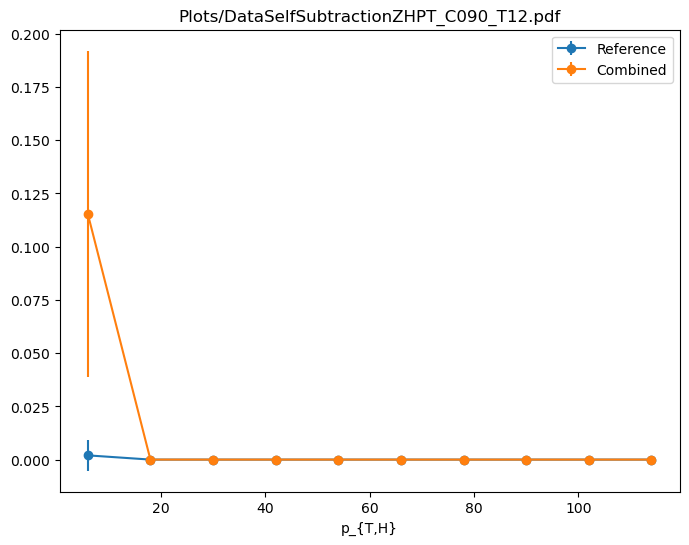

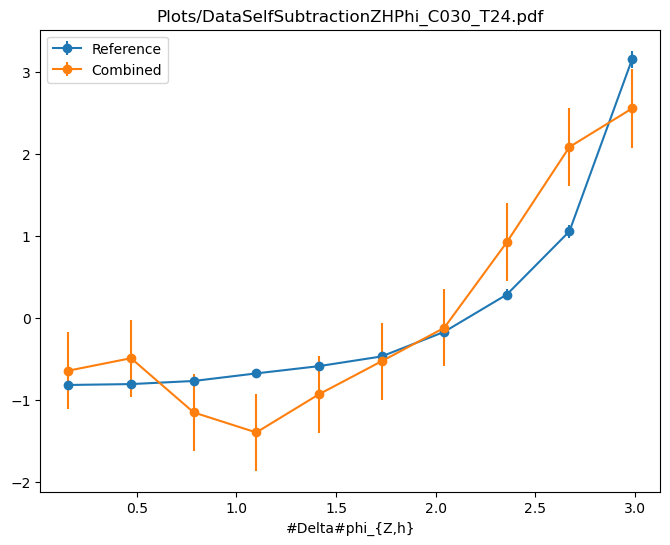

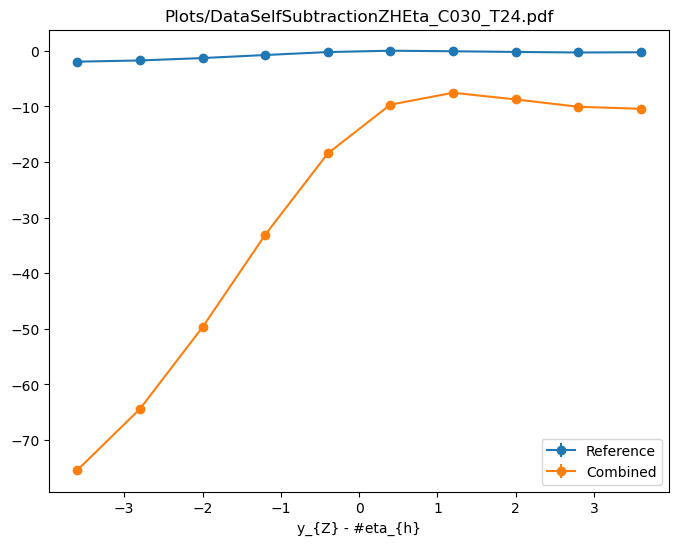

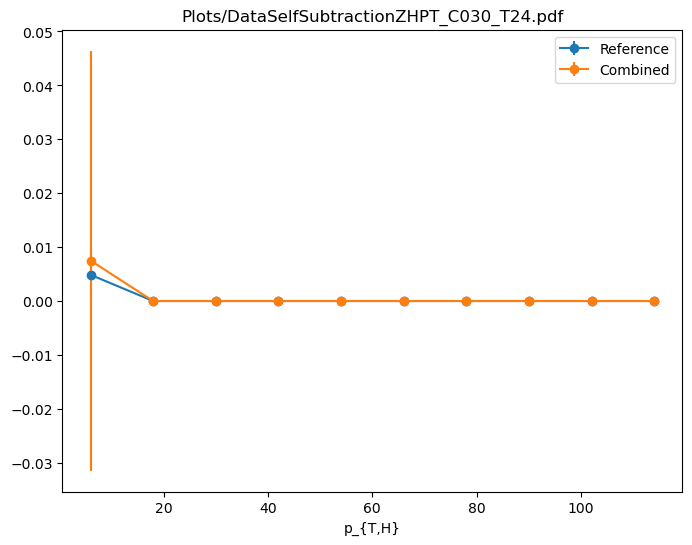

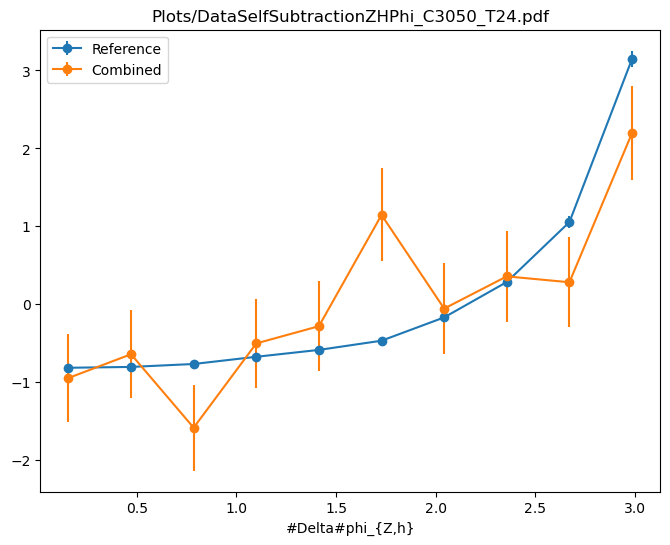

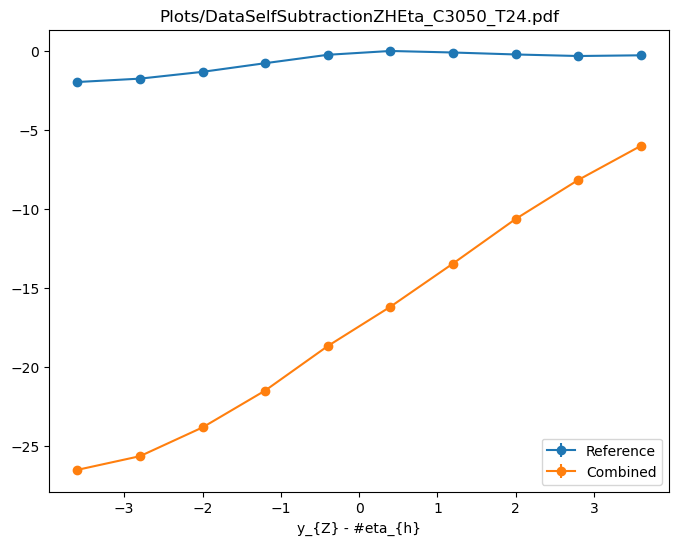

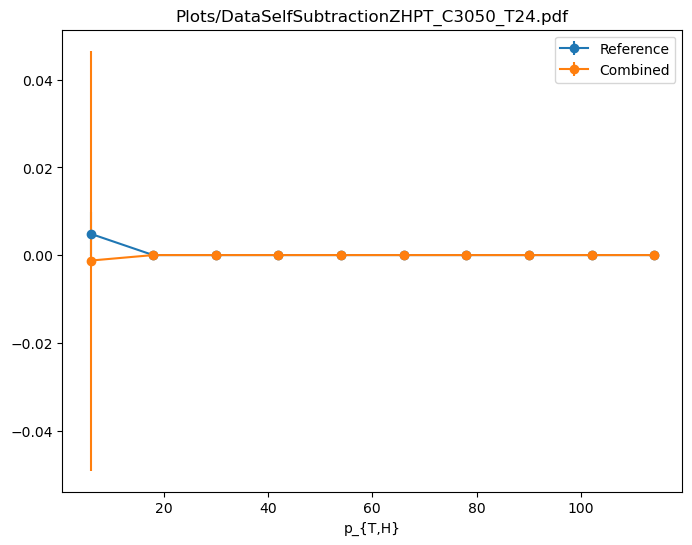

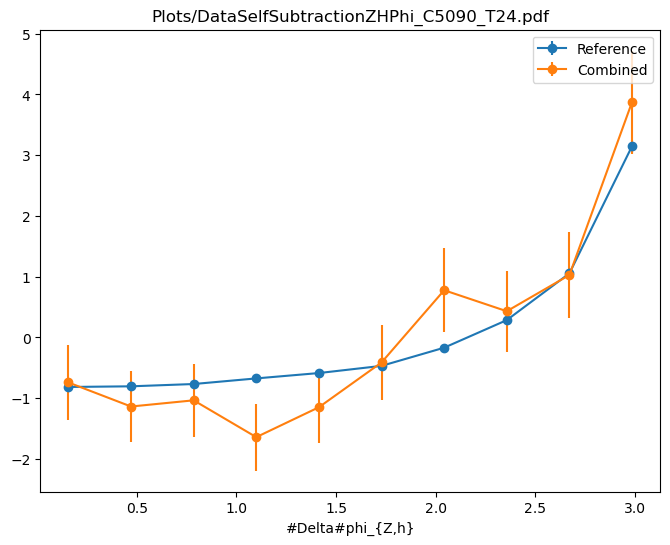

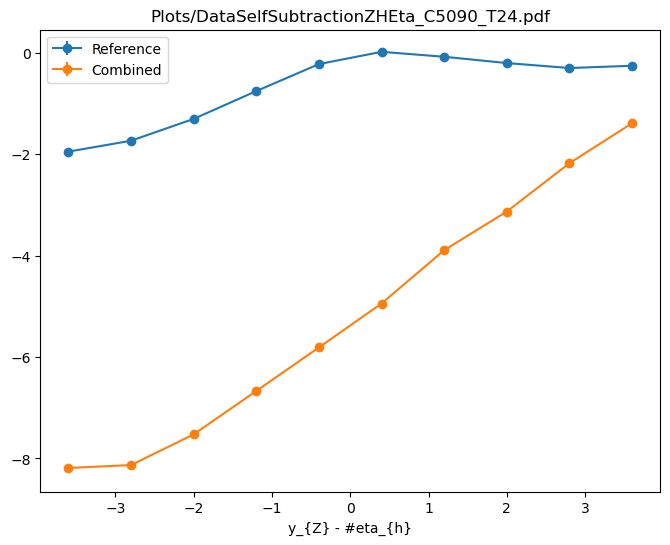

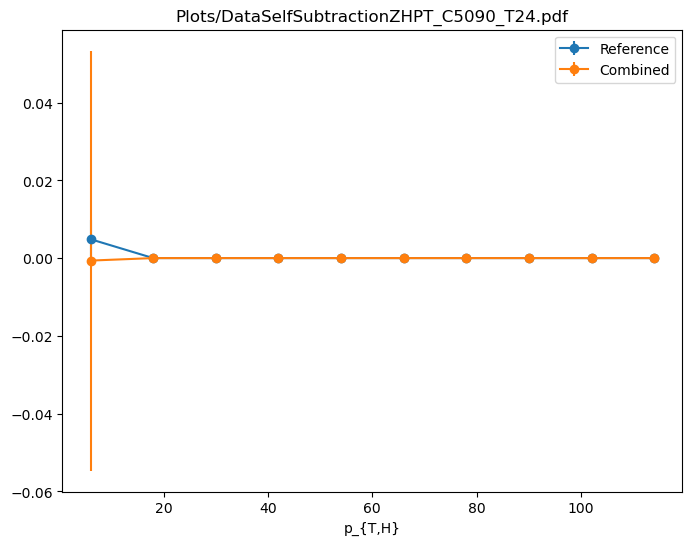

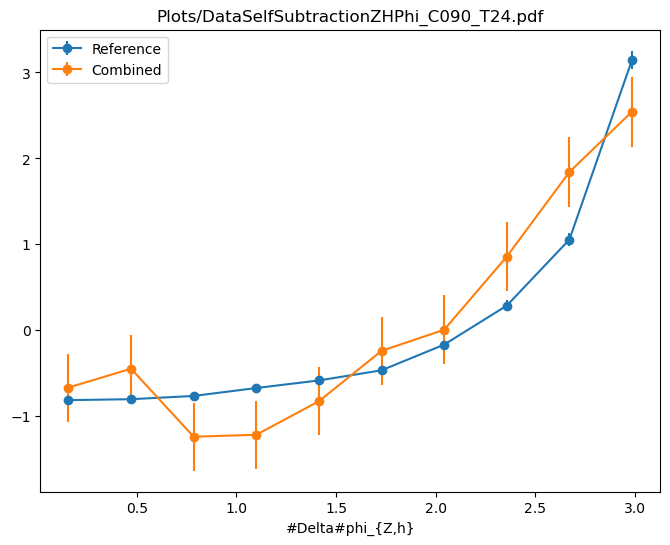

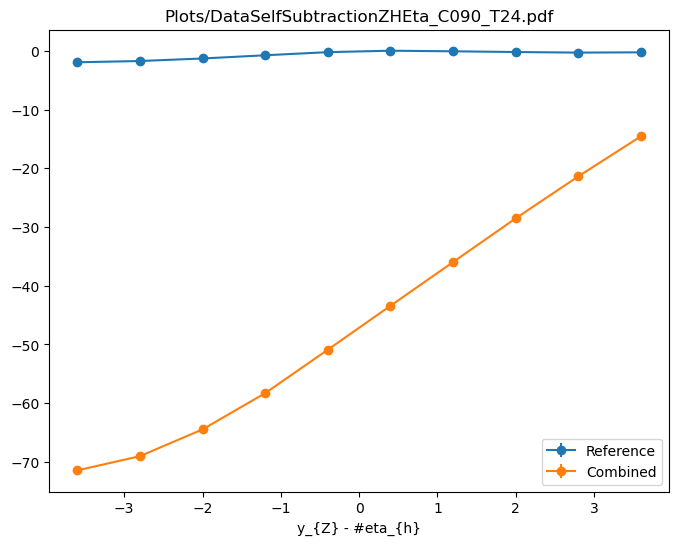

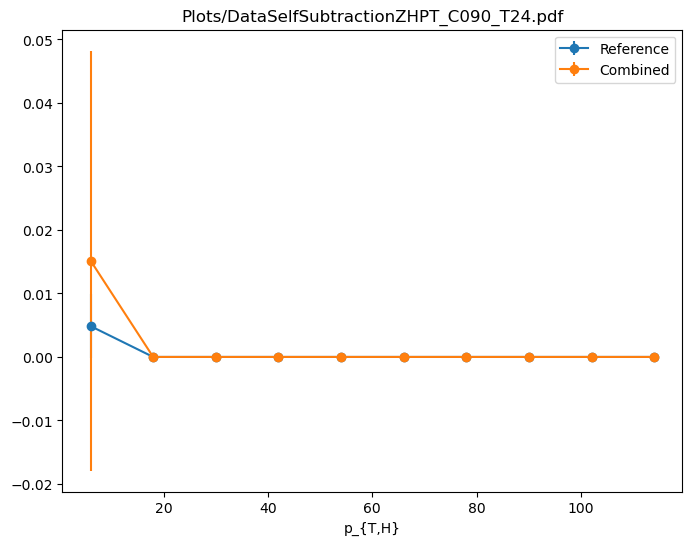

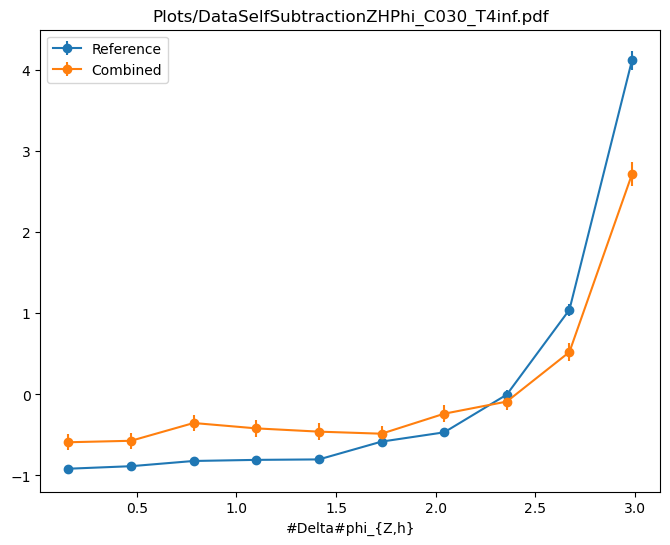

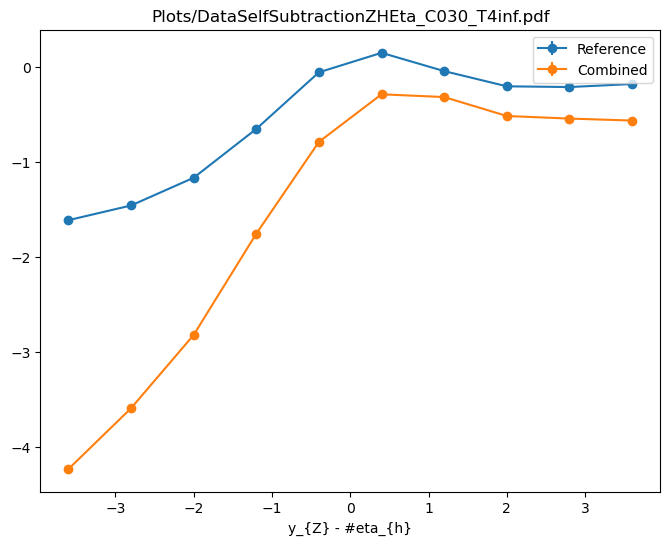

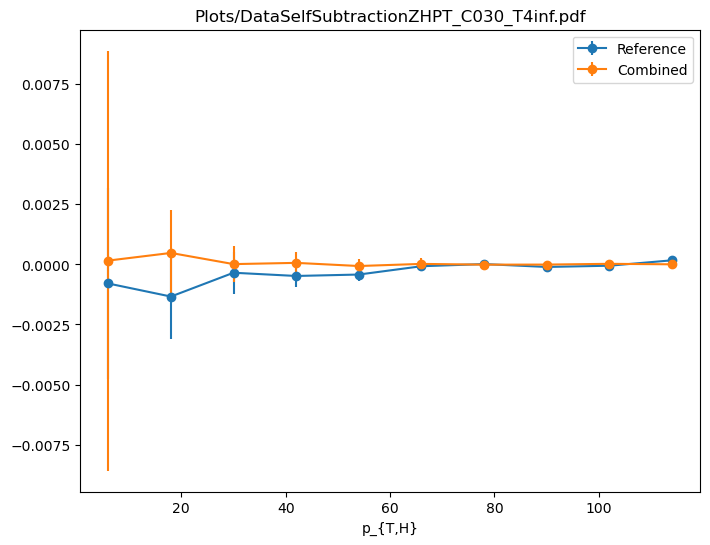

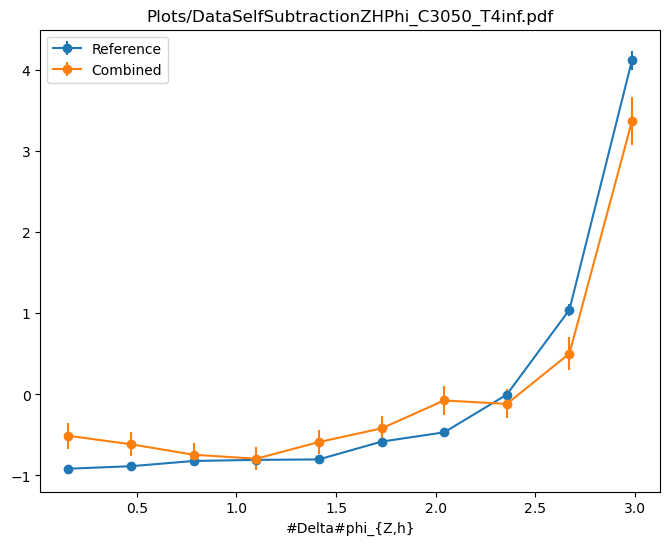

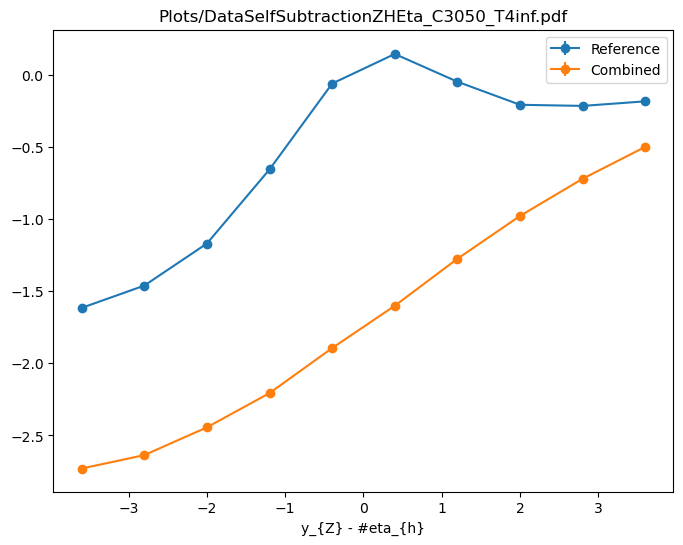

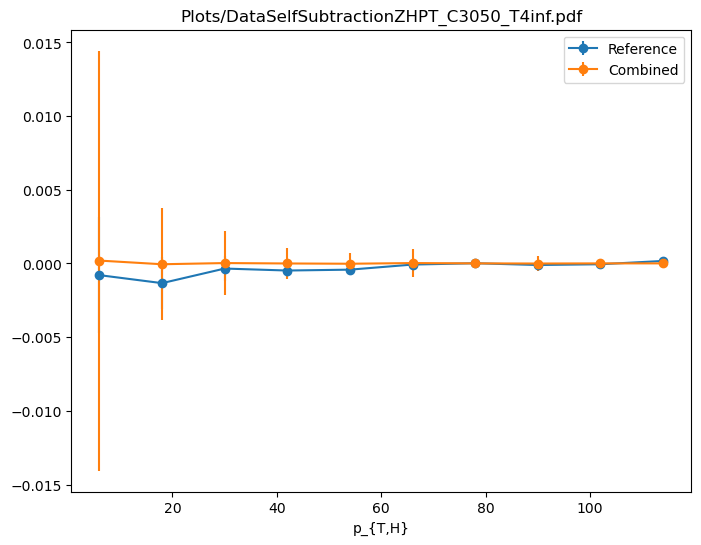

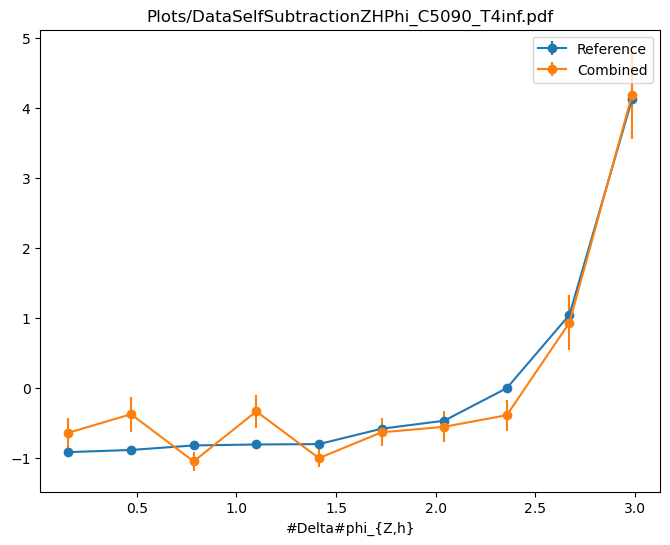

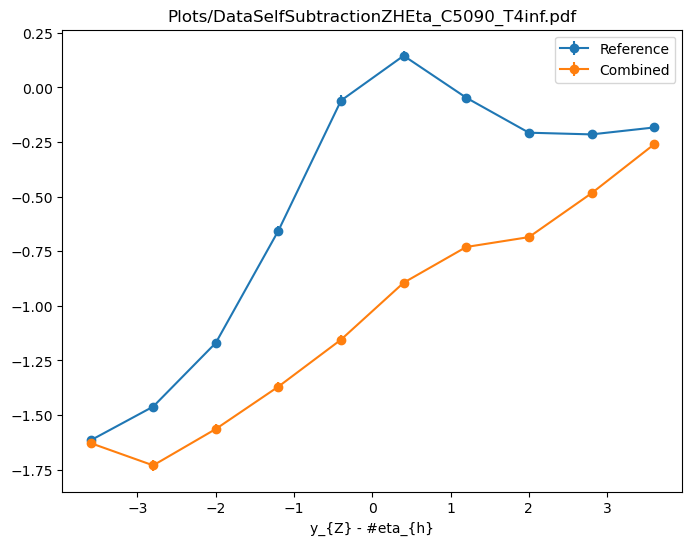

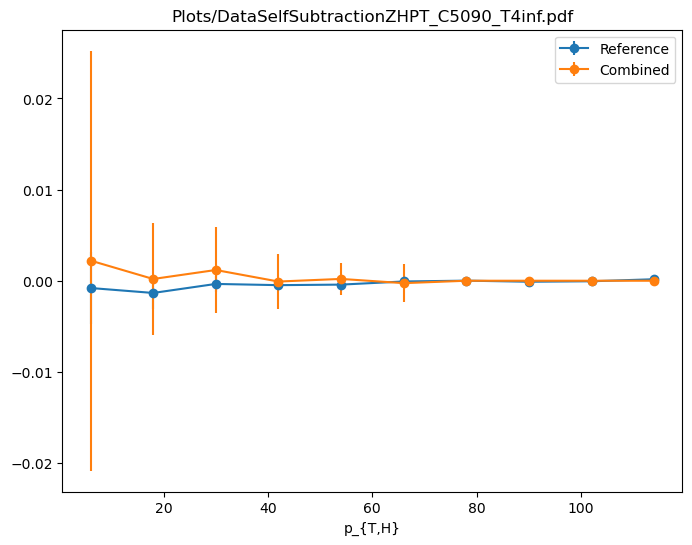

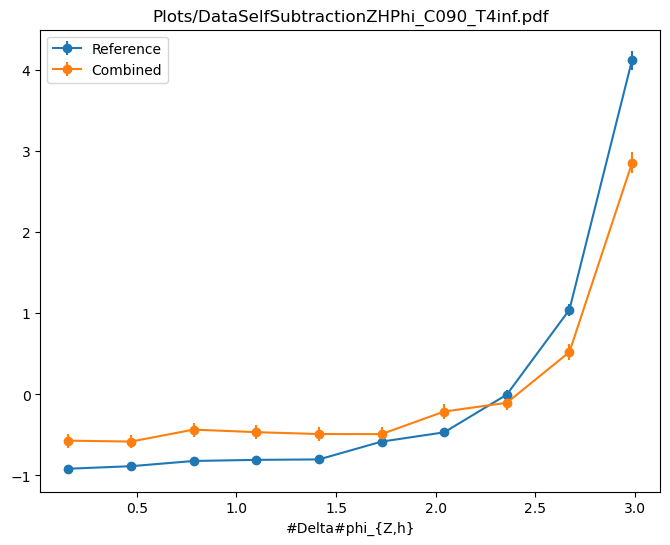

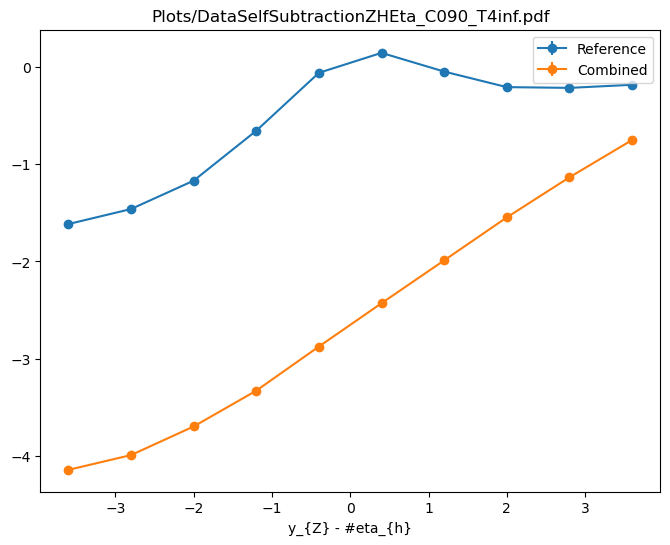

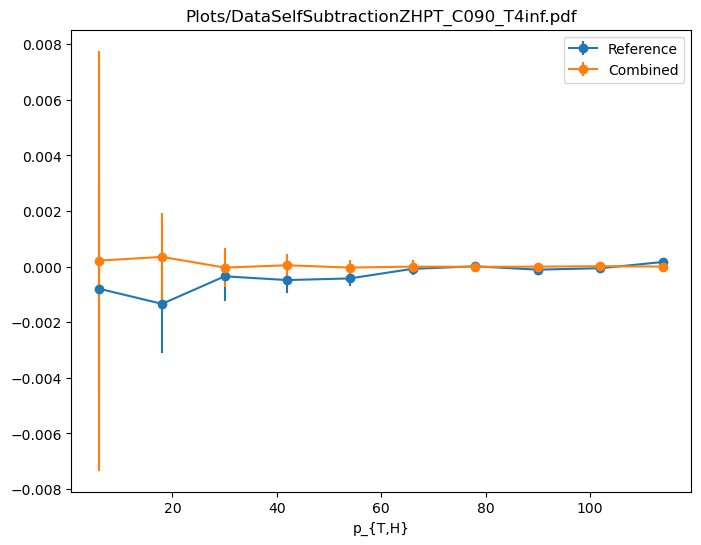

Warning in <TH1D::Add>: Histograms have different axis limits
Warning in <TH1D::Add>: Histograms have different axis limits
Warning in <TH1D::Add>: Histograms have different axis limits
Warning in <TH1D::Add>: Histograms have different axis limits
Warning in <TH1D::Add>: Histograms have different axis limits
Warning in <TH1D::Add>: Histograms have different axis limits
Warning in <TH1D::Add>: Histograms have different axis limits
Info in <TH1D::Add>: Histograms have different axis limits - trying to use TH1::Merge
Error in <Merge>: Cannot merge histograms - limits are inconsistent:
 first: HistDiff (10, -4.000000, 4.000000), second: HZHEta (10, 0.000000, 3.500000)
Warning in <TH1D::Add>: Histograms have different axis limits
Warning in <TH1D::Add>: Histograms have different axis limits
Warning in <TH1D::Add>: Histograms have different axis limits
Warning in <TH1D::Add>: Histograms have different axis limits
Warning in <TH1D::Add>: Histograms have different axis limits
Info in <TH1D::Ad

In [7]:
# Data self mixing check for Z-hadron

for T in ["12", "24", "4inf"]:
    for C in ["030", "3050", "5090", "090"]:
        for P in ["ZHPhi", "ZHEta", "ZHPT"]:
            MakeQuickPlot(f"Plots/DataSelfSubtraction{P}_C{C}_T{T}.pdf",
                [f"PPDataxPPData_Reco{T}.root",
                     f"PPDataxPPData_Reco{T}_Different.root",
                     f"PbPbDataxPbPbData_Centrality{C}_Reco{T}.root",
                     f"PbPbDataxPbPbData_Centrality{C}_Reco{T}_Different.root"],
                f"H{P}",
                [1, -1, 0, 0],
                [0, 0, 1, -1],
                12)

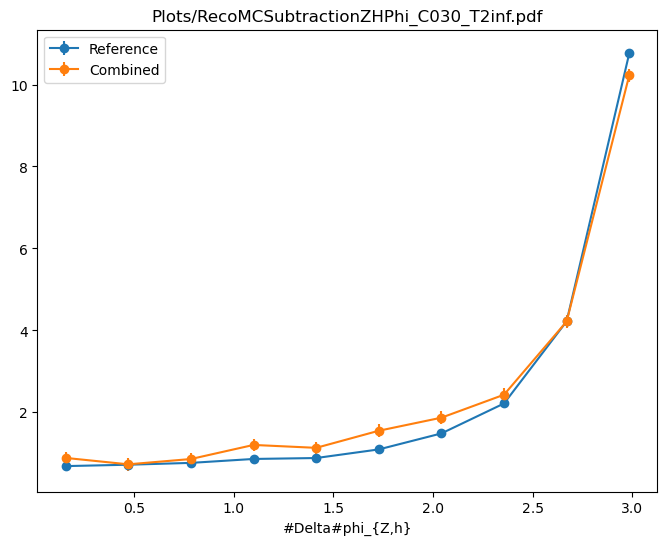

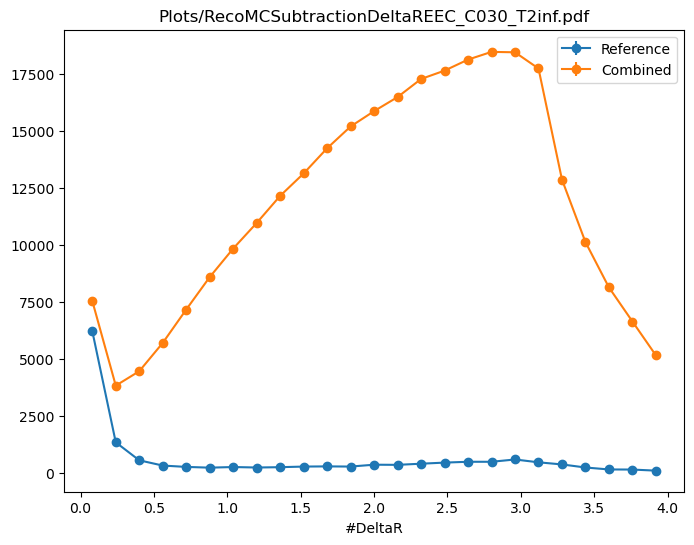

In [8]:
# MC 0-30% closure plots

MakeQuickPlot("Plots/RecoMCSubtractionZHPhi_C030_T2inf.pdf",
    ["DYLLS0xDYLLS0.root",
        "PPMCxPPMC_Reco.root",
        "DYLLxDYLL_Centrality030_Reco.root",
        "DYLLxHydjet_Centrality030_Reco.root"],
    "HZHPhi",
    [0, 1, 0, 0],
    [0, 0, 1, -1],
    12)
MakeQuickPlot("Plots/RecoMCSubtractionDeltaREEC_C030_T2inf.pdf",
    ["DYLLS0xDYLLS0.root",
       "PPMCxPPMC_Reco.root",
       "DYLLxDYLL_Centrality030_Reco.root",
       "DYLLxHydjet_Centrality030_Reco.root",
       "HydjetxHydjet_Centrality030_Reco.root",
       "HydjetxHydjet_Centrality030_Reco_Different.root"],
    "HDeltaREEC",
    [0, 1, 0, 0, 0, 0],
    [0, 0, 1, -2, -1, 2],
    4)

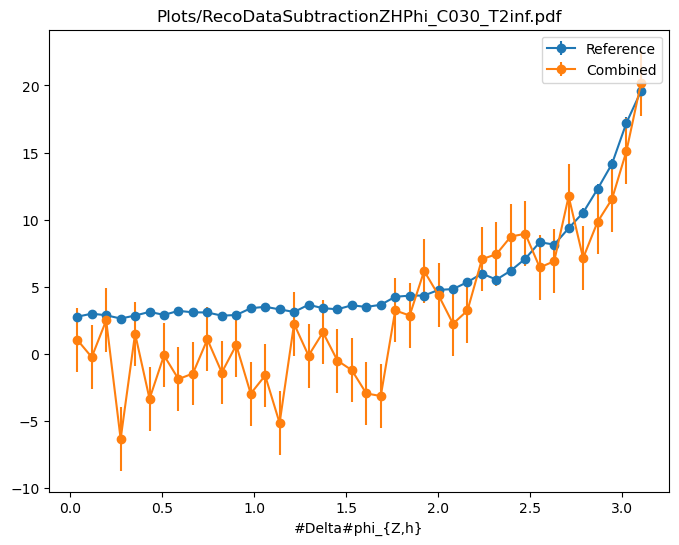

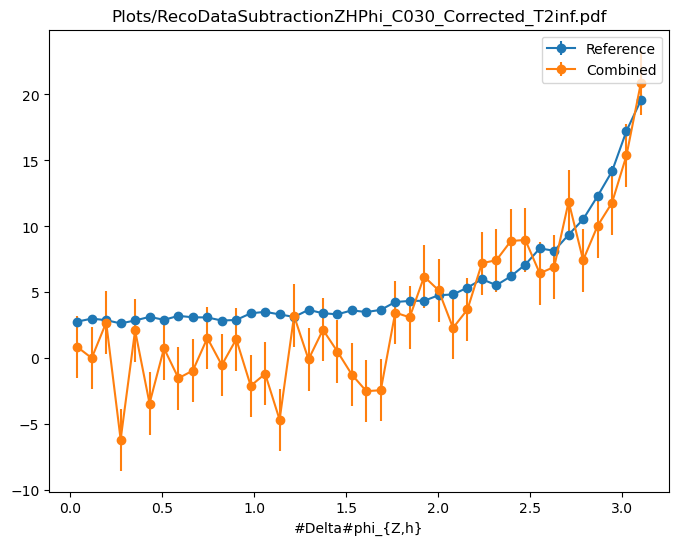

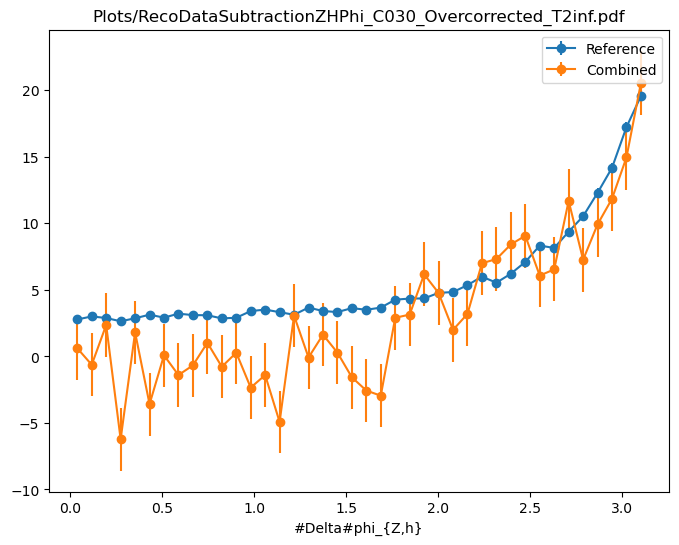

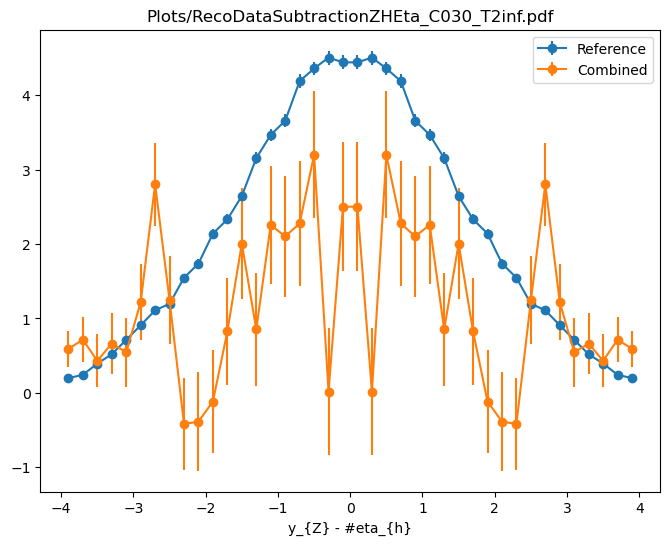

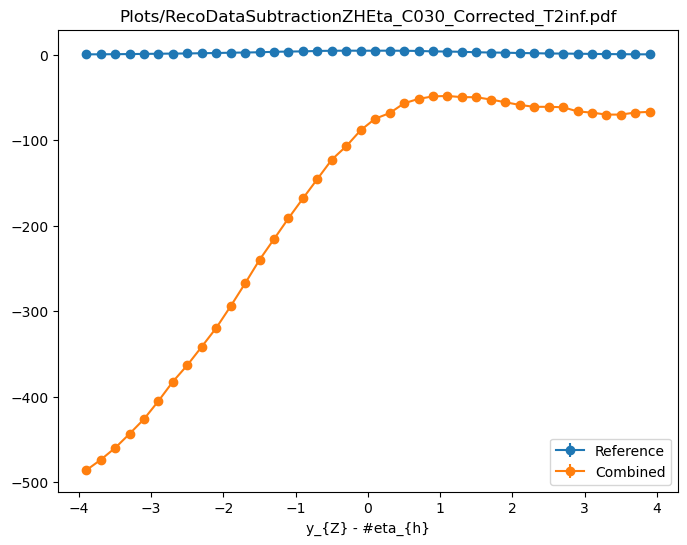

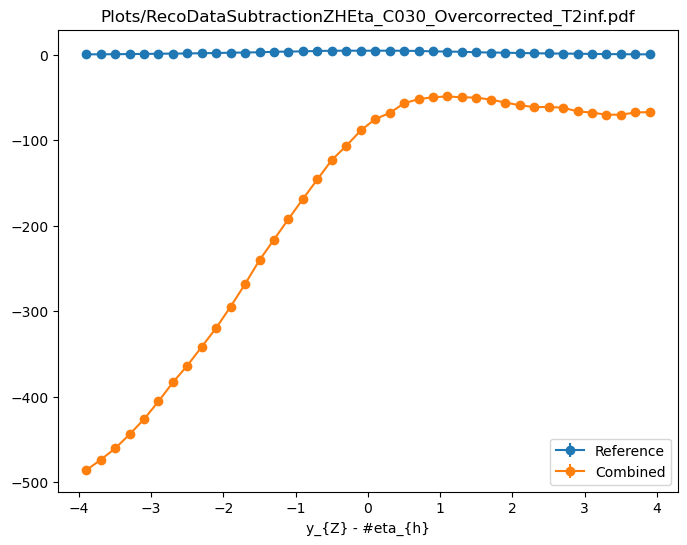

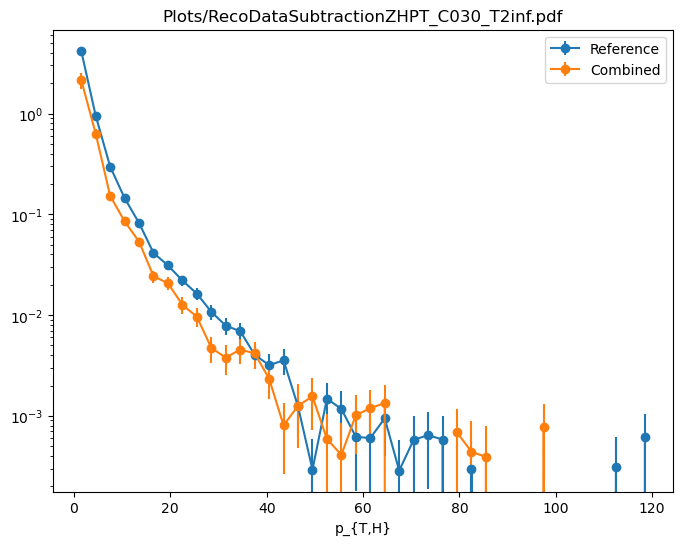

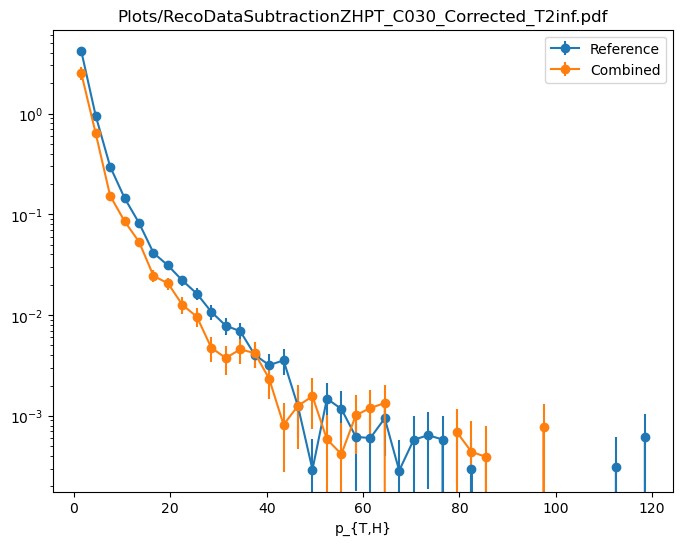

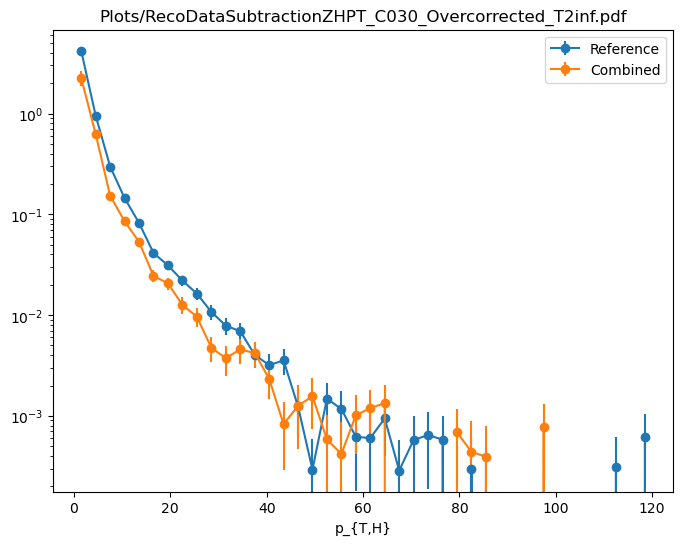

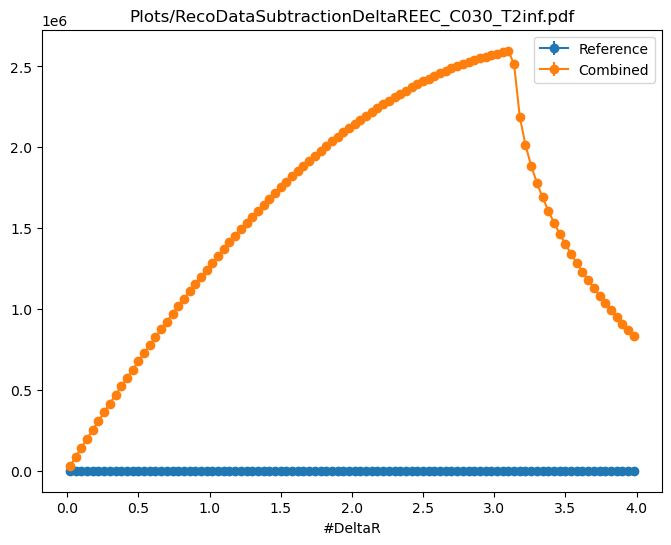

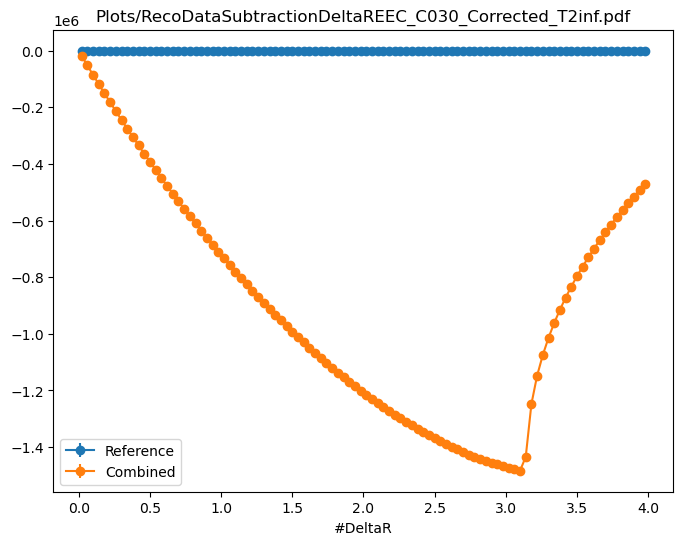

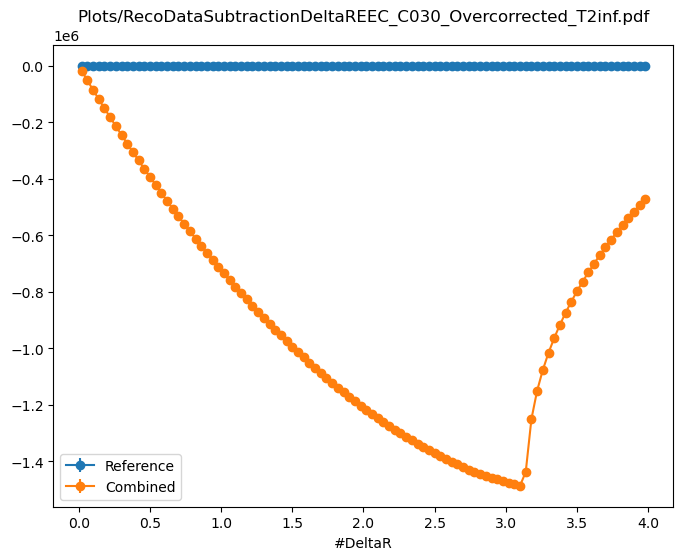

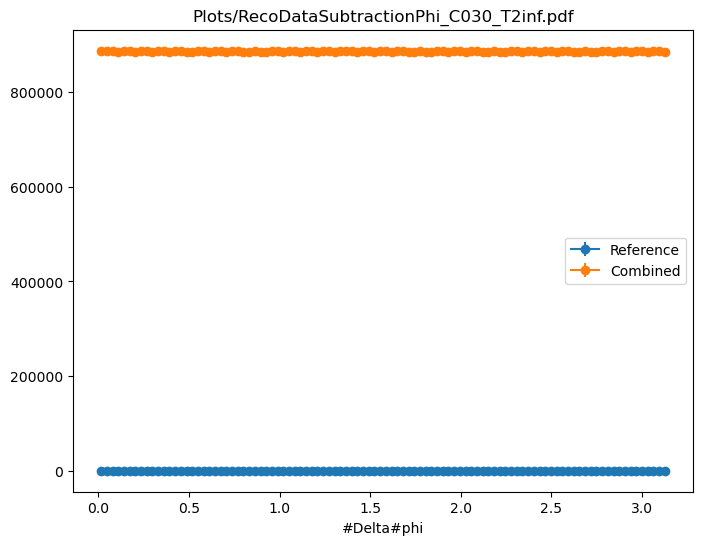

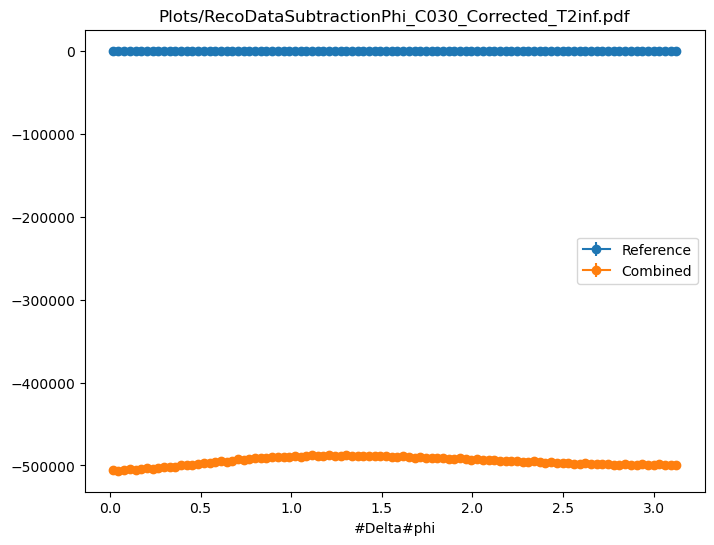

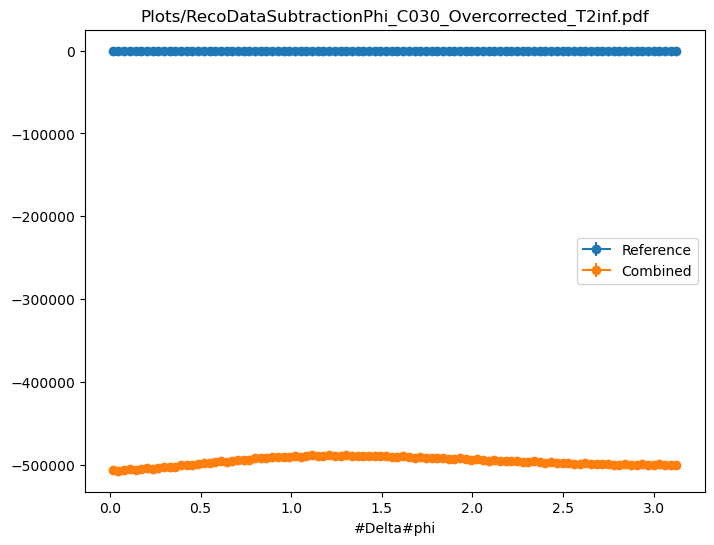

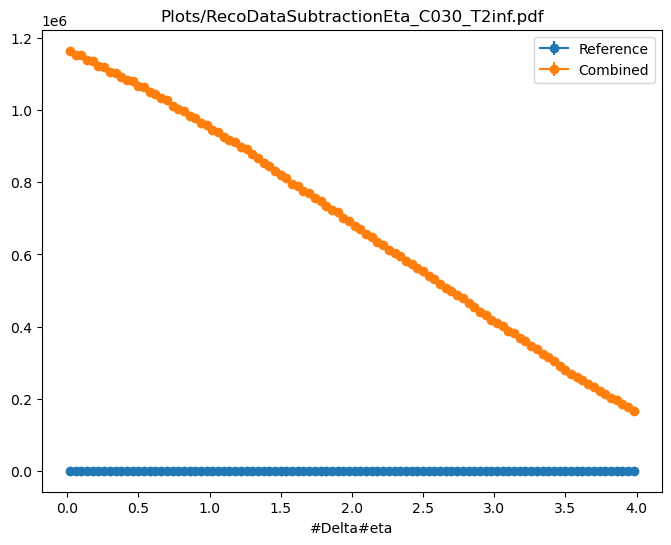

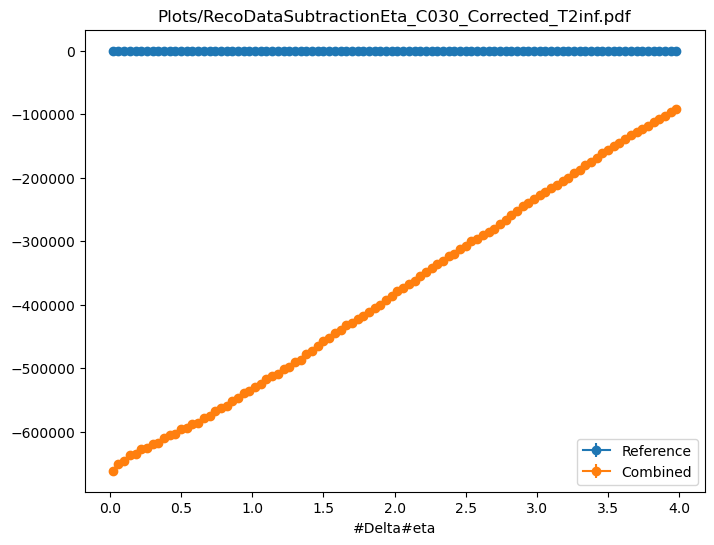

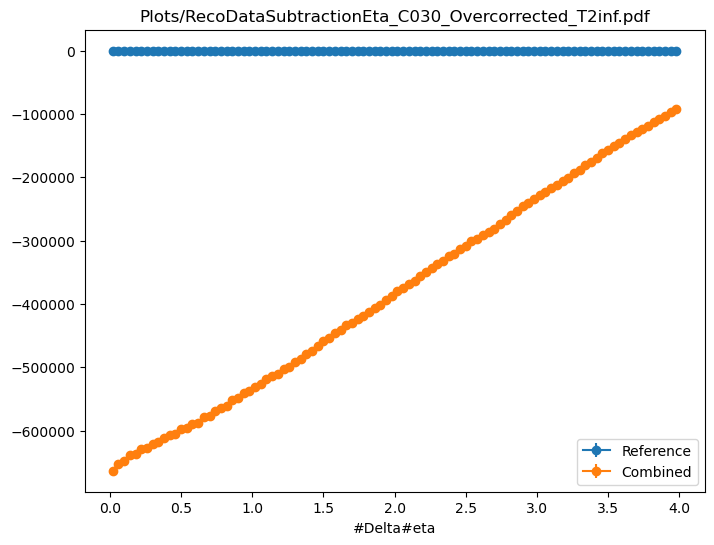

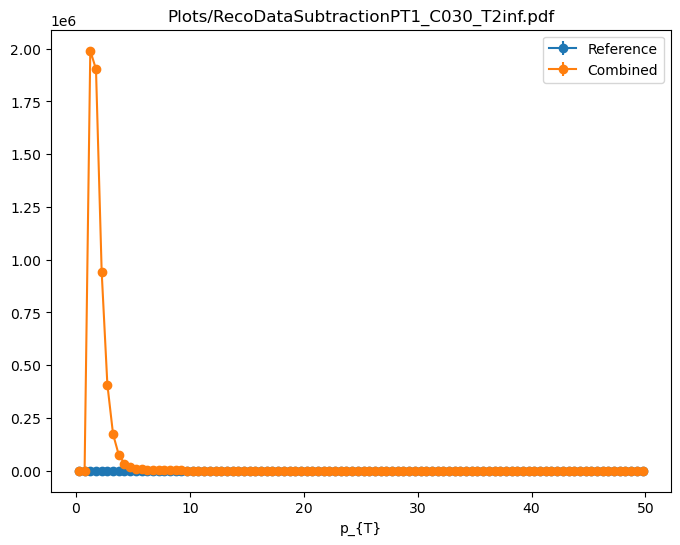

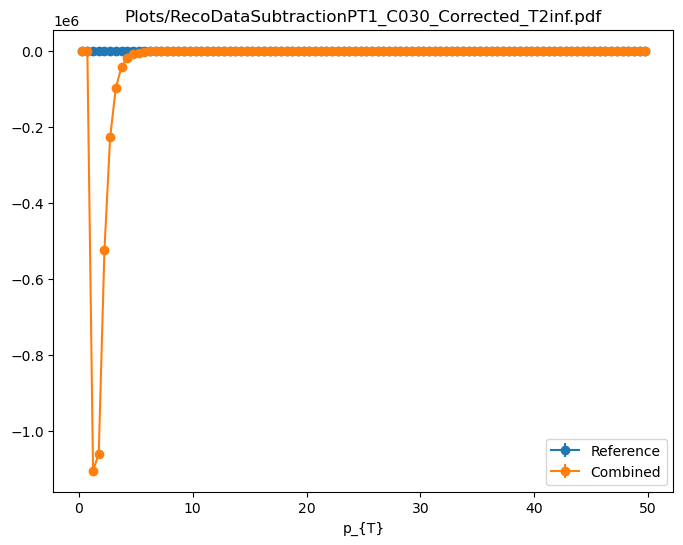

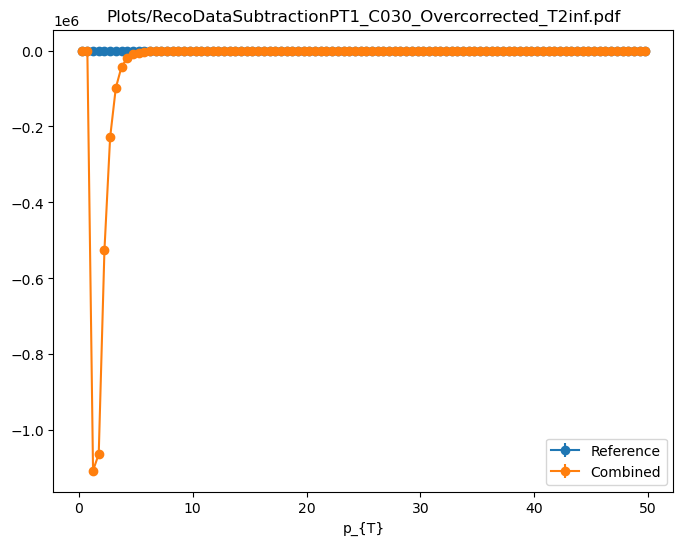

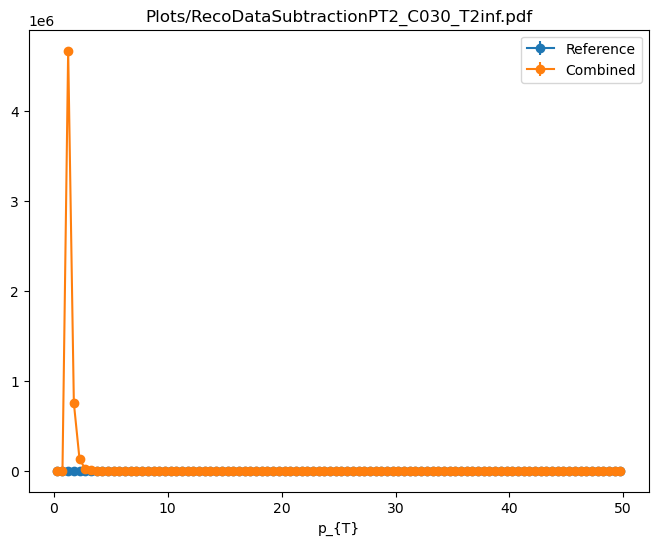

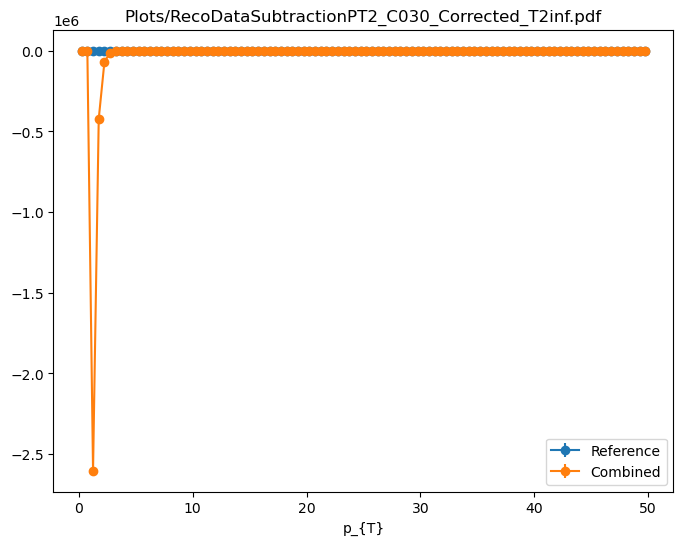

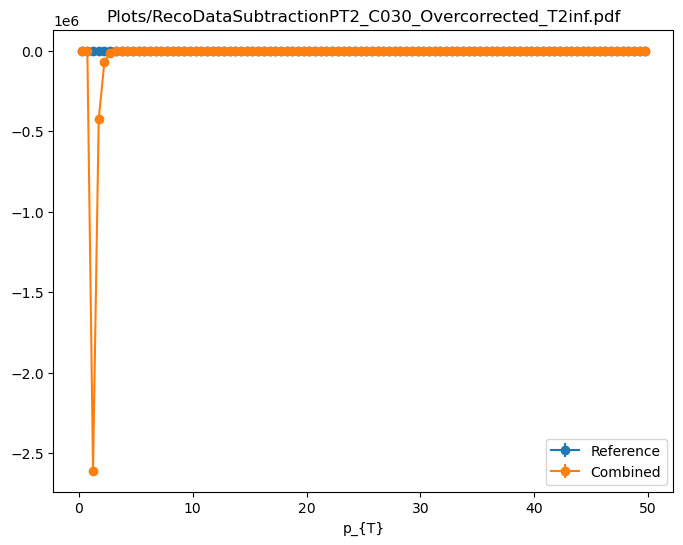

Warning in <TH1D::Add>: Histograms have different axis limits
Warning in <TH1D::Add>: Histograms have different axis limits
Warning in <TH1D::Add>: Histograms have different axis limits
Warning in <TH1D::Add>: Histograms have different axis limits
Warning in <TH1D::Add>: Histograms have different axis limits
Warning in <TH1D::Add>: Histograms have different axis limits
Warning in <TH1D::Add>: Histograms have different axis limits
Warning in <TH1D::Add>: Histograms have different axis limits
Warning in <TH1D::Add>: Histograms have different axis limits
Warning in <TH1D::Add>: Histograms have different axis limits
Warning in <TH1D::Add>: Histograms have different axis limits
Warning in <TH1D::Add>: Histograms have different axis limits
Warning in <TH1D::Add>: Histograms have different axis limits
Warning in <TH1D::Add>: Histograms have different axis limits
Warning in <TH1D::Add>: Histograms have different axis limits
Warning in <TH1D::Add>: Histograms have different axis limits
Warning 

In [9]:
for P in ["ZHPhi", "ZHEta", "ZHPT"]:
    MakeQuickPlot(f"Plots/RecoDataSubtraction{P}_C030_T2inf.pdf",
        ["PPDataxPPData_Reco.root",
            "PPMCxPPMC_Reco.root",
            "PbPbDataxPbPbData_Centrality030_Reco.root",
            "PbPbDataxMinBiasData_Centrality030_Reco.root"],
        f"H{P}",
        [1, 0, 0, 0],
        [0, 0, 1, -1],
        3, True if P == "ZHPT" else False)
    MakeQuickPlot(f"Plots/RecoDataSubtraction{P}_C030_Corrected_T2inf.pdf",
        ["PPDataxPPData_Reco.root",
            "PPMCxPPMC_Reco.root",
            "PbPbDataxPbPbData_Centrality030_Reco.root",
            "PbPbDataxMinBiasData_Centrality030_Corrected_Reco.root"],
        f"H{P}",
        [1, 0, 0, 0],
        [0, 0, 1, -1],
        3, True if P == "ZHPT" else False)
    MakeQuickPlot(f"Plots/RecoDataSubtraction{P}_C030_Overcorrected_T2inf.pdf",
        ["PPDataxPPData_Reco.root",
            "PPMCxPPMC_Reco.root",
            "PbPbDataxPbPbData_Centrality030_Reco.root",
            "PbPbDataxMinBiasData_Centrality030_Overcorrected_Reco.root"],
        f"H{P}",
        [1, 0, 0, 0],
        [0, 0, 1, -1],
        3, True if P == "ZHPT" else False)

for P in ["DeltaREEC", "Phi", "Eta", "PT1", "PT2"]:
    MakeQuickPlot(f"Plots/RecoDataSubtraction{P}_C030_T2inf.pdf",
        ["PPDataxPPData_Reco.root",
           "PPMCxPPMC_Reco.root",
           "PbPbDataxPbPbData_Centrality030_Reco.root",
           "PbPbDataxMinBiasData_Centrality030_Reco.root",
           "MinBiasDataxMinBiasData_Centrality030_Reco.root",
           "MinBiasDataxMinBiasData_Centrality030_Reco_Different.root"],
        f"H{P}",
        [1, 0, 0, 0, 0, 0],
        [0, 0, 1, -2, -1, 2],
        1)
    MakeQuickPlot(f"Plots/RecoDataSubtraction{P}_C030_Corrected_T2inf.pdf",
        ["PPDataxPPData_Reco.root",
           "PPMCxPPMC_Reco.root",
           "PbPbDataxPbPbData_Centrality030_Reco.root",
           "PbPbDataxMinBiasData_Centrality030_Corrected_Reco.root",
           "MinBiasDataxMinBiasData_Centrality030_Corrected_Reco.root",
           "MinBiasDataxMinBiasData_Centrality030_Corrected_Reco_Different.root"],
        f"H{P}",
        [1, 0, 0, 0, 0, 0],
        [0, 0, 1, -2, -1, 2],
        1)
    MakeQuickPlot(f"Plots/RecoDataSubtraction{P}_C030_Overcorrected_T2inf.pdf",
        ["PPDataxPPData_Reco.root",
           "PPMCxPPMC_Reco.root",
           "PbPbDataxPbPbData_Centrality030_Reco.root",
           "PbPbDataxMinBiasData_Centrality030_Overcorrected_Reco.root",
           "MinBiasDataxMinBiasData_Centrality030_Overcorrected_Reco.root",
           "MinBiasDataxMinBiasData_Centrality030_Overcorrected_Reco_Different.root"],
        f"H{P}",
        [1, 0, 0, 0, 0, 0],
        [0, 0, 1, -2, -1, 2],
        1)

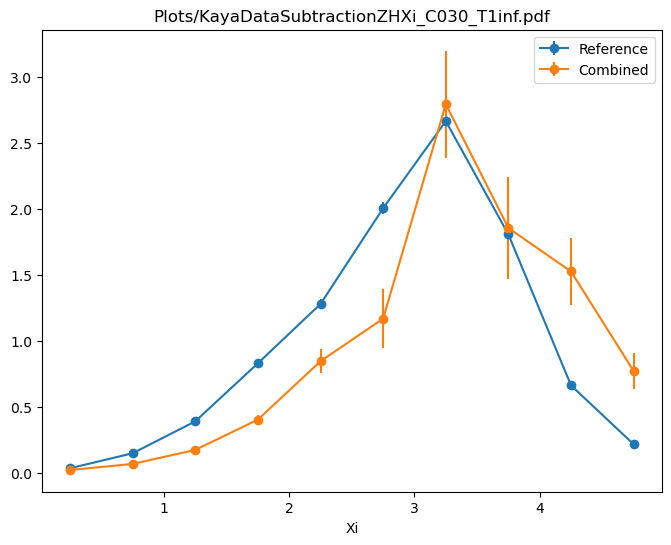

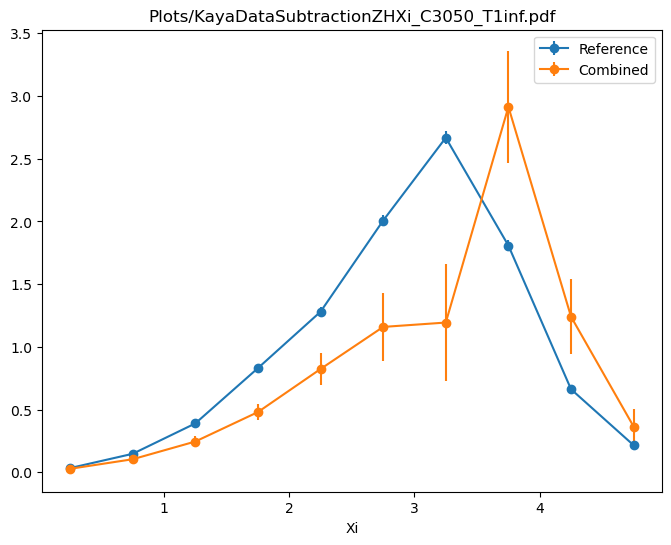

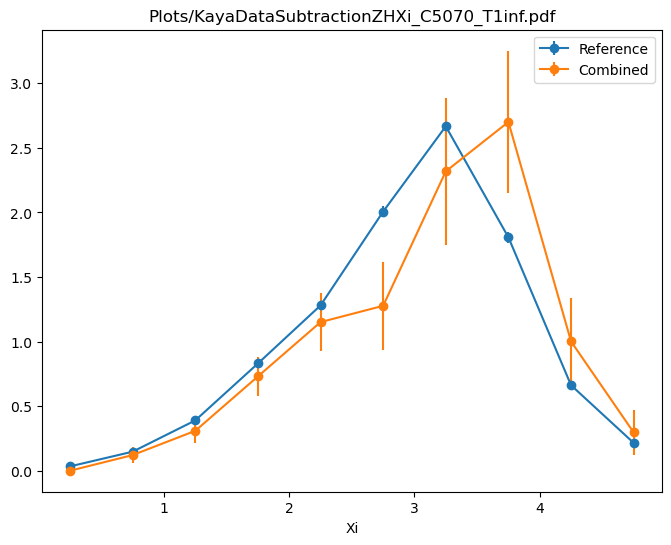

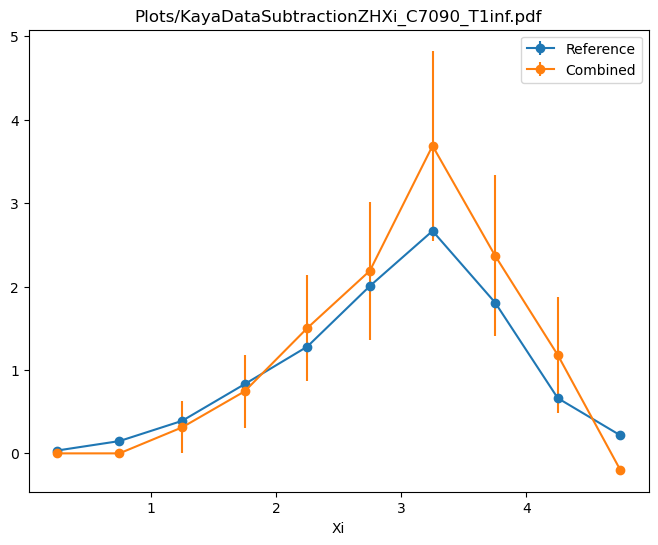

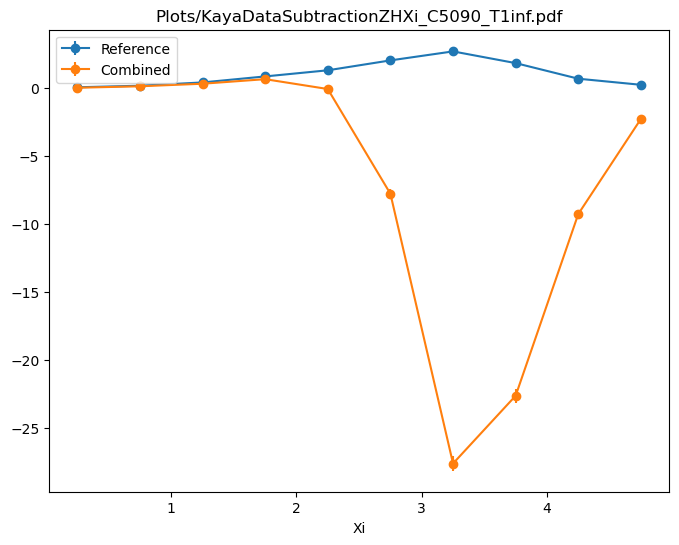

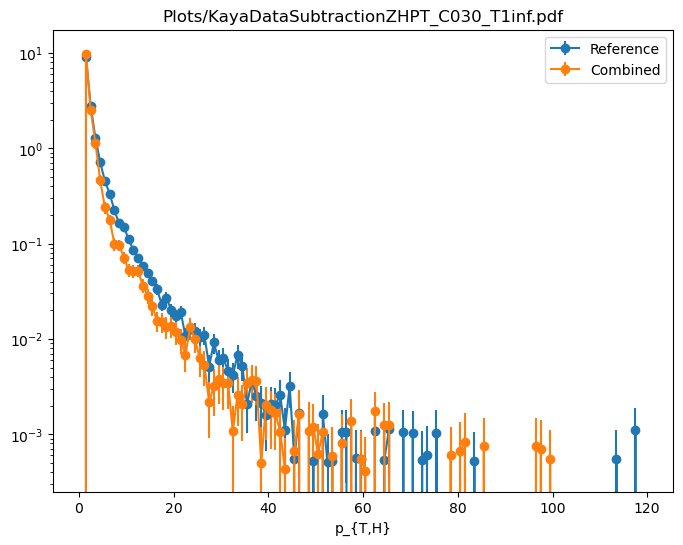

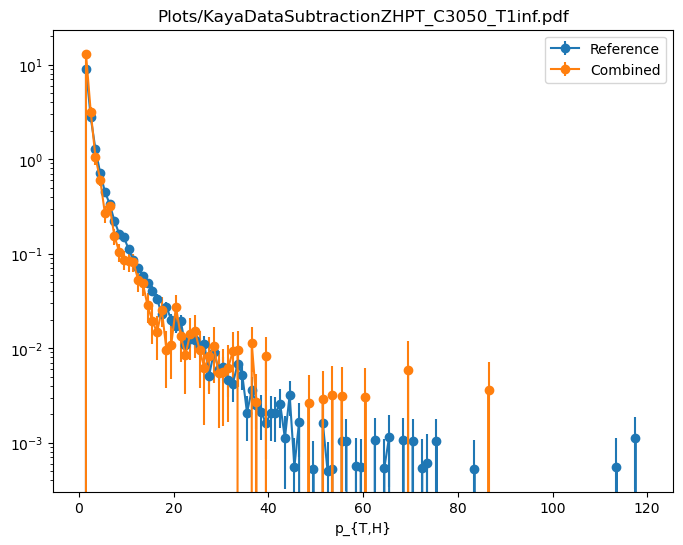

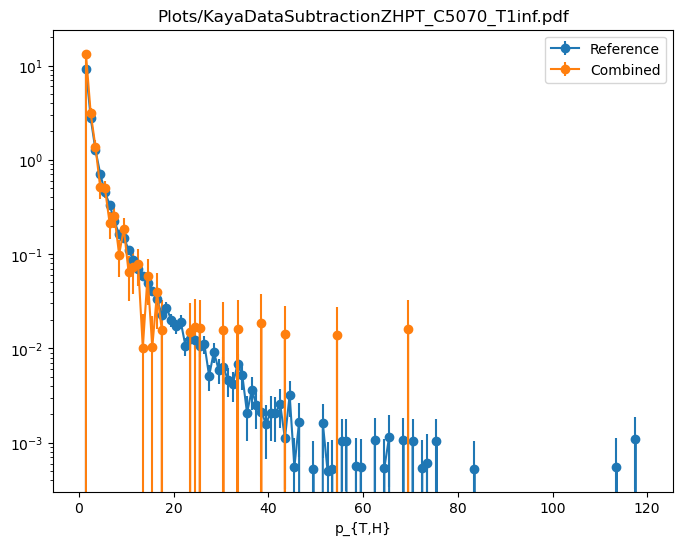

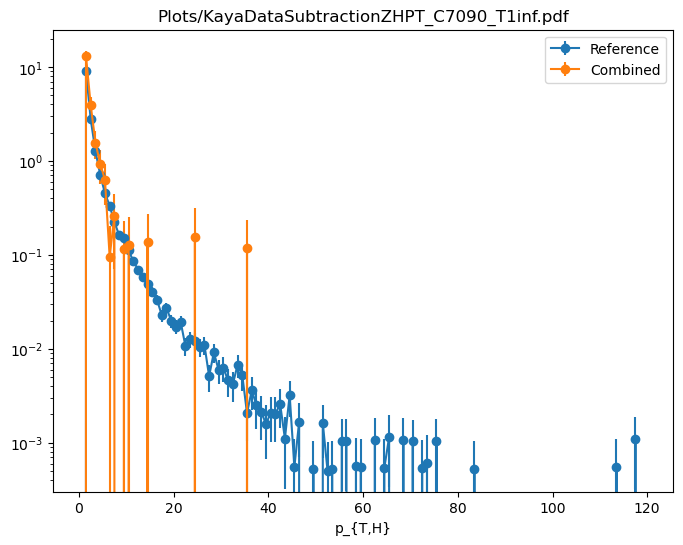

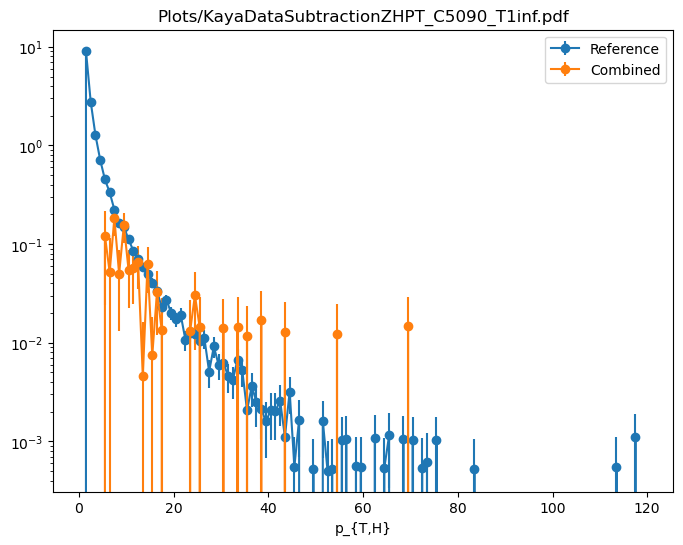

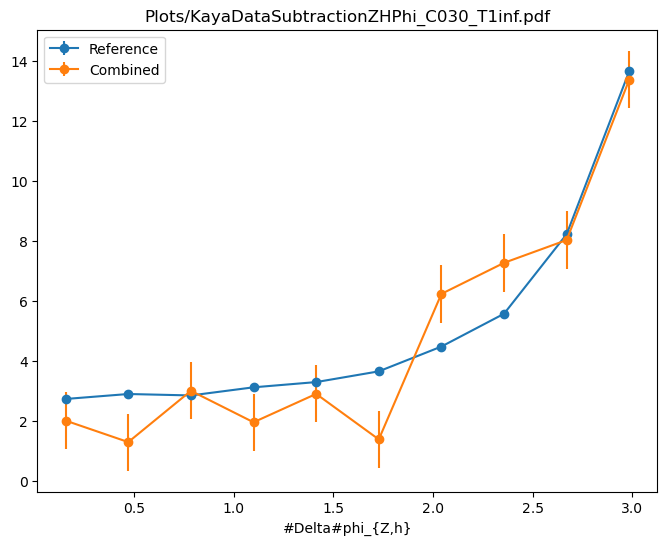

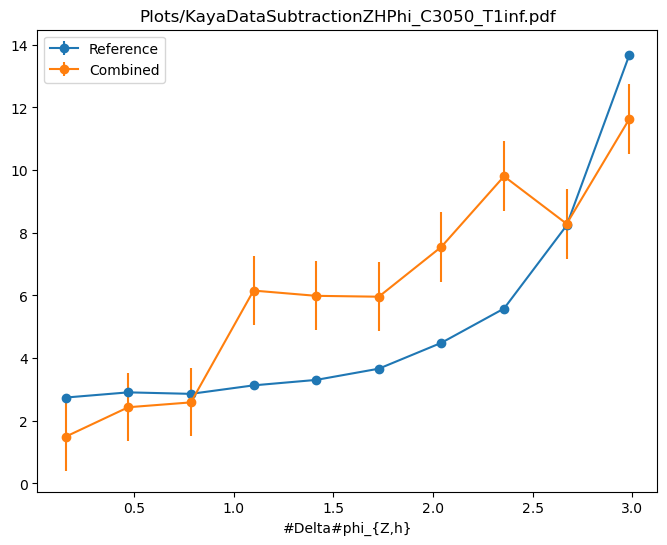

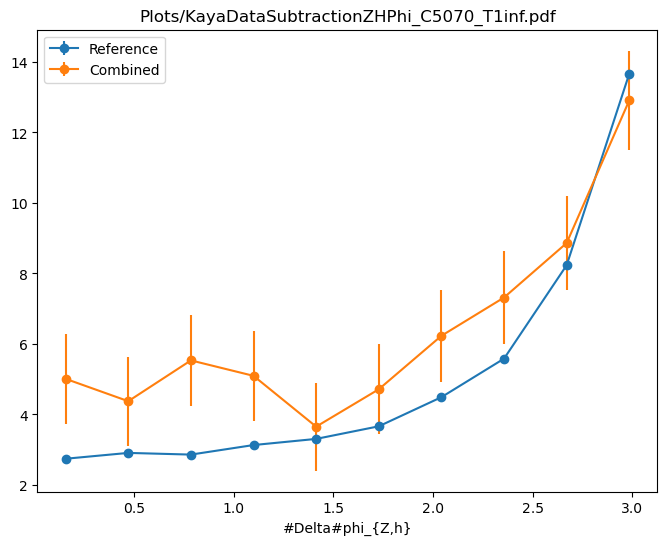

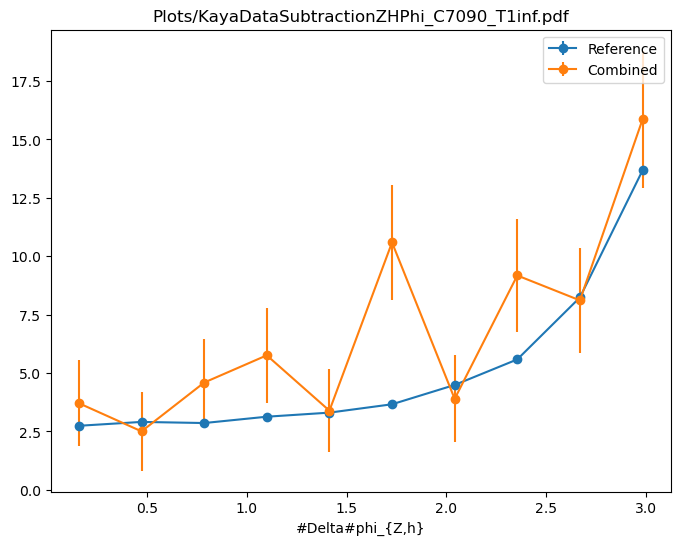

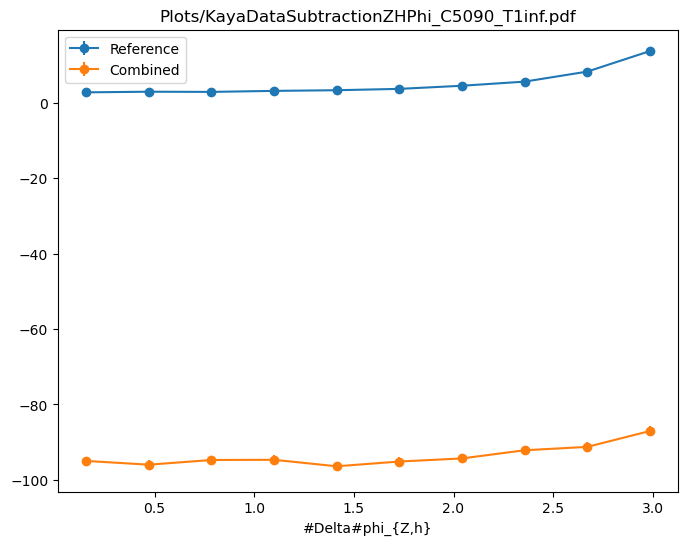

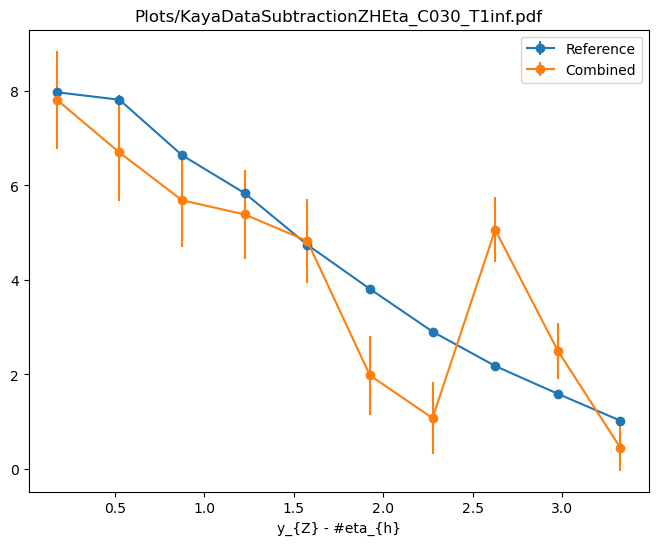

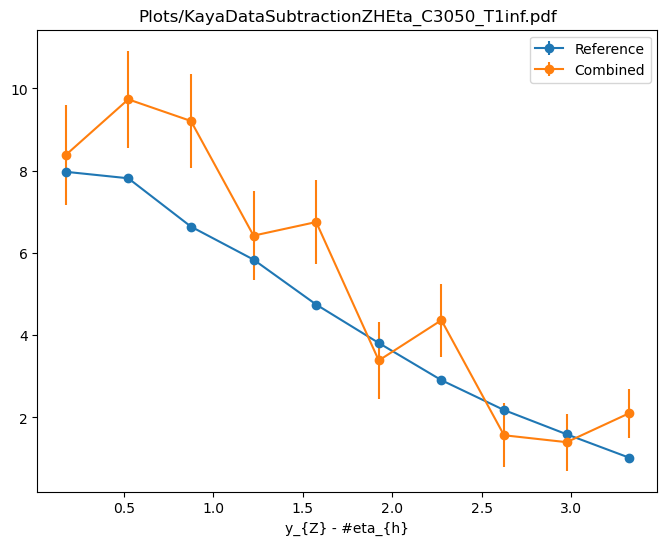

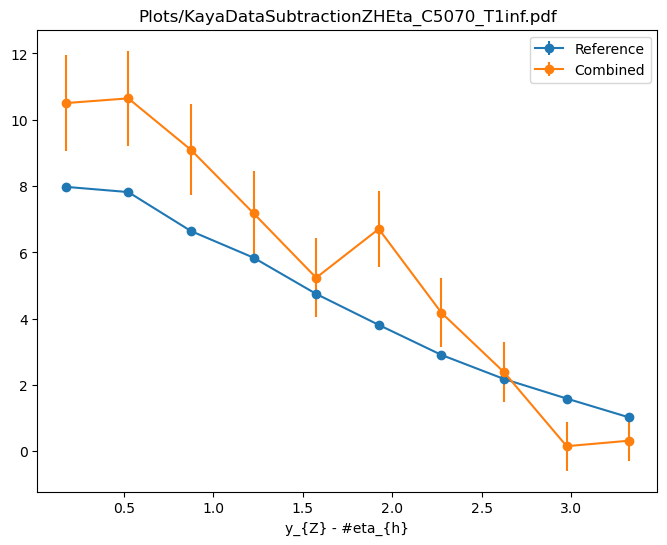

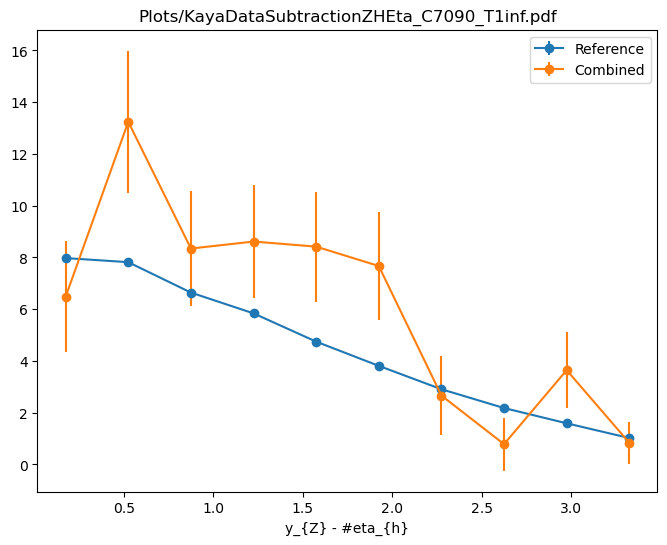

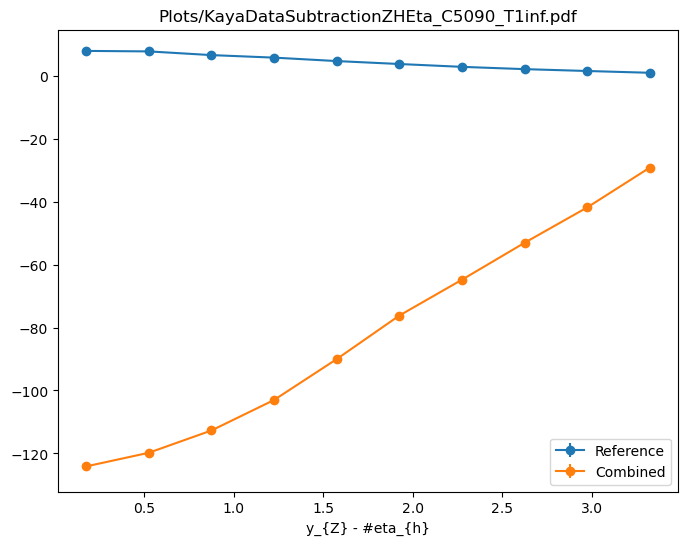

In [10]:
# Kaya reproduction

for P in ["ZHXi", "ZHPT", "ZHPhi", "ZHEta"]:
    for C in ["030", "3050", "5070", "7090", "5090"]:
        MakeQuickPlot(f"Plots/KayaDataSubtraction{P}_C{C}_T1inf.pdf",
            ["PPDataxPPData_Kaya.root",
                "PPMCxPPMC_Kaya.root",
                f"PbPbDataxPbPbData_Centrality{C}_Kaya.root",
                f"PbPbDataxMinBiasData_Centrality{C}_Kaya.root"],
            f"H{P}",
            [1, 0, 0, 0],
            [0, 0, 1, -1],
            1 if P == "ZHPT" else 12, True if P == "ZHPT" else False)


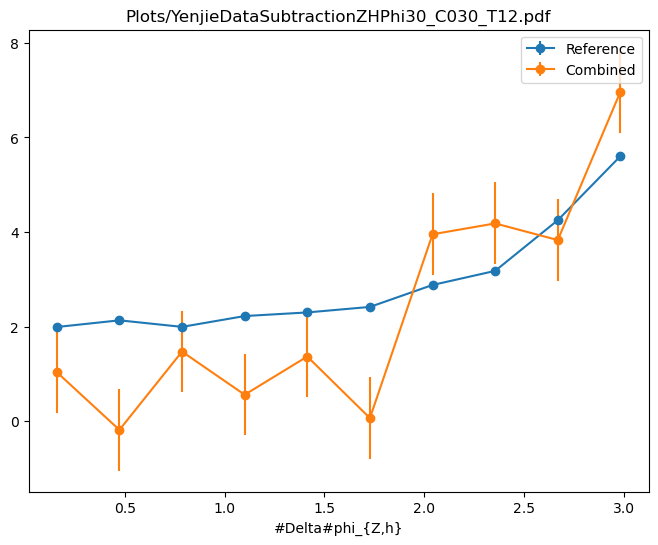

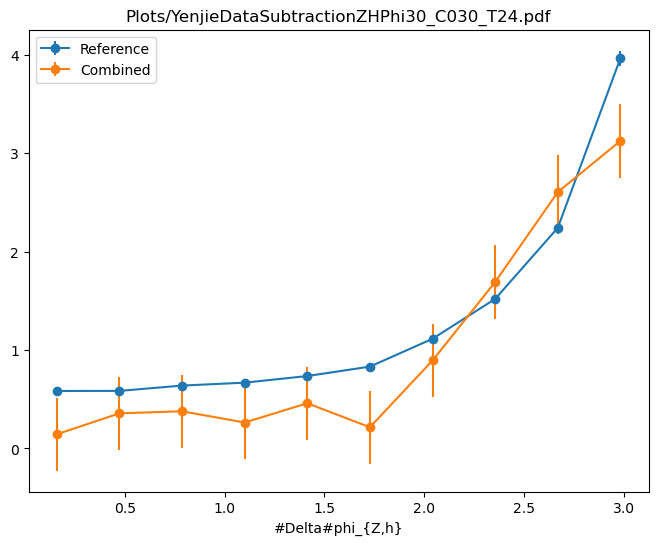

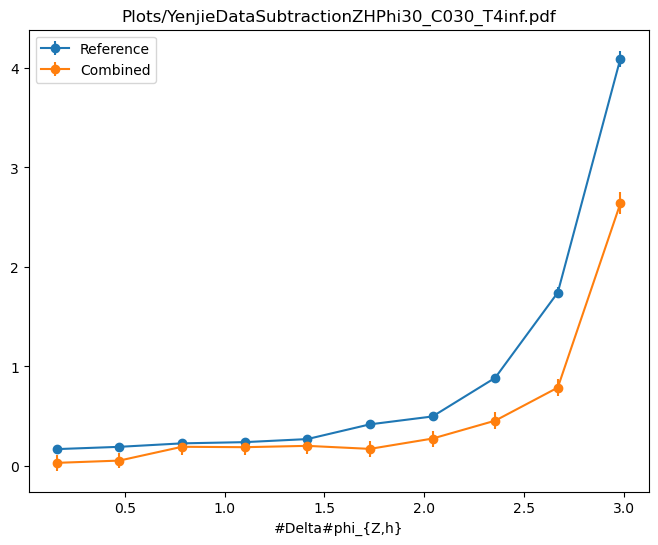

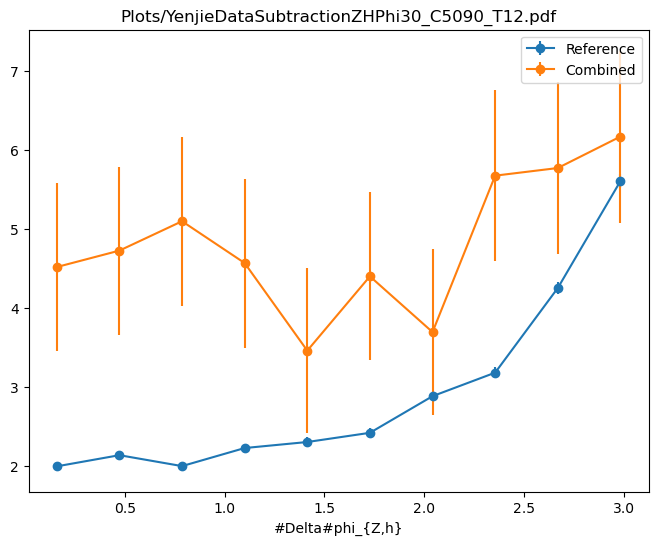

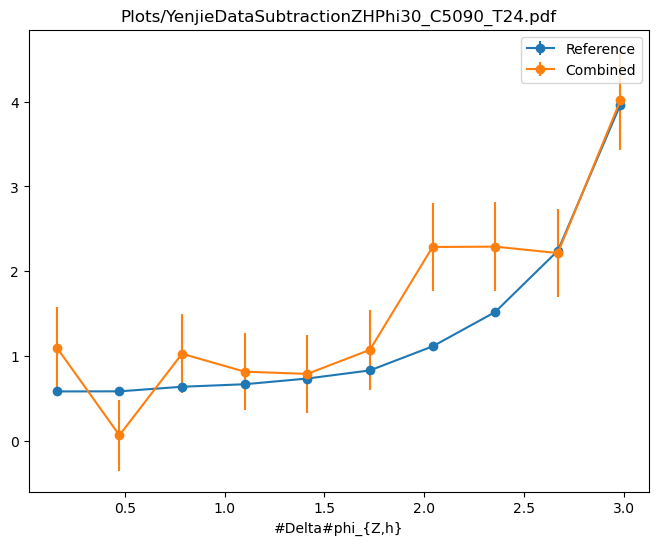

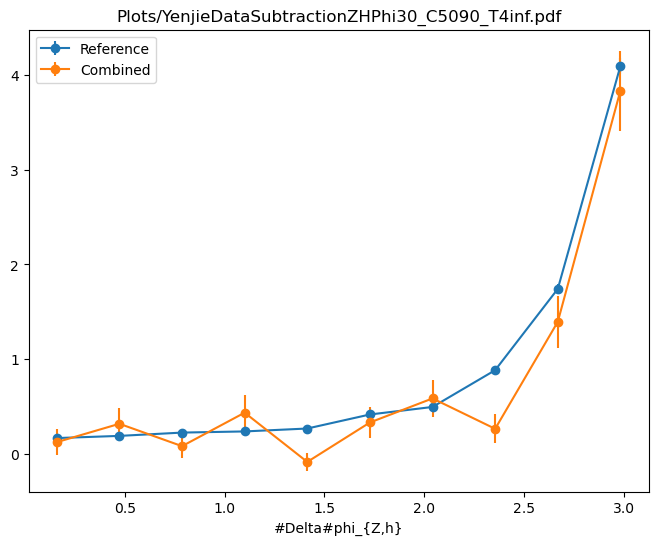

In [11]:
# Yenjie reproduction

for P in ["ZHPhi"]:
    for C in ["030", "5090"]:
        for T in ["T12", "T24", "T4inf"]:
            MakeQuickPlot(f"Plots/YenjieDataSubtraction{P}30_C{C}_{T}.pdf",
                [f"PPDataxPPData_{T}_Yenjie30.root",
                    f"PbPbDataxPbPbData_Centrality{C}_{T}_Yenjie30.root",
                    f"PbPbDataxMinBiasData_Centrality{C}_{T}_Yenjie30.root"],
                f"H{P}",
                [1, 0, 0],
                [0, 1, -1],
                12, False)


In [72]:
662.677-114.349*math.exp(-0.125020*40)

661.9071386341157

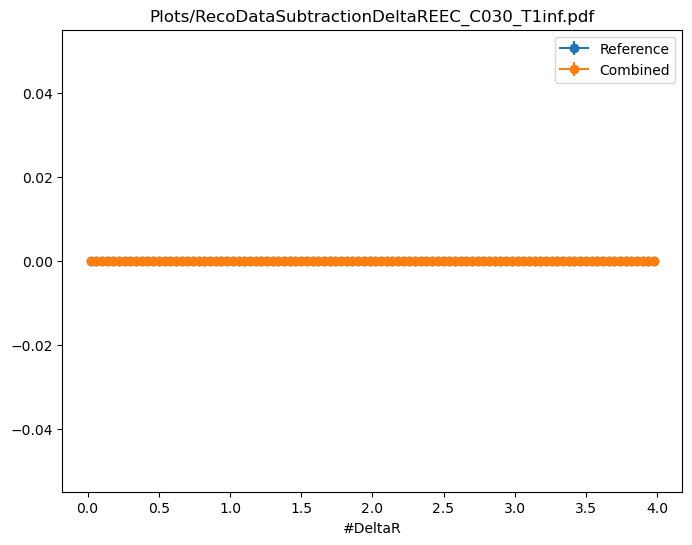

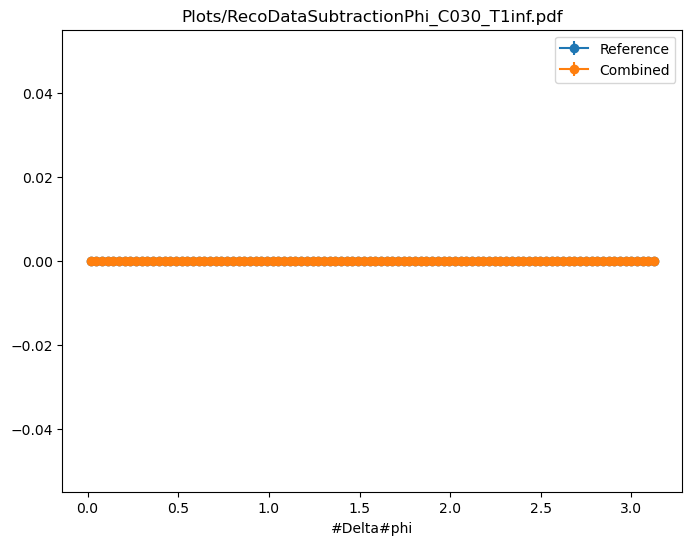

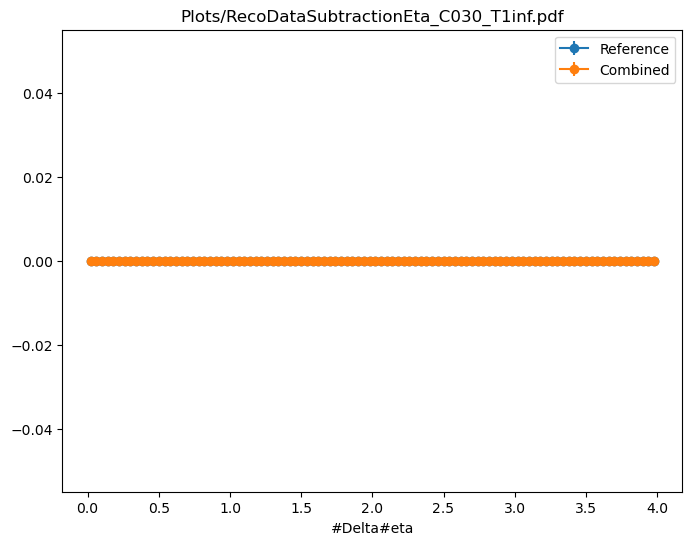

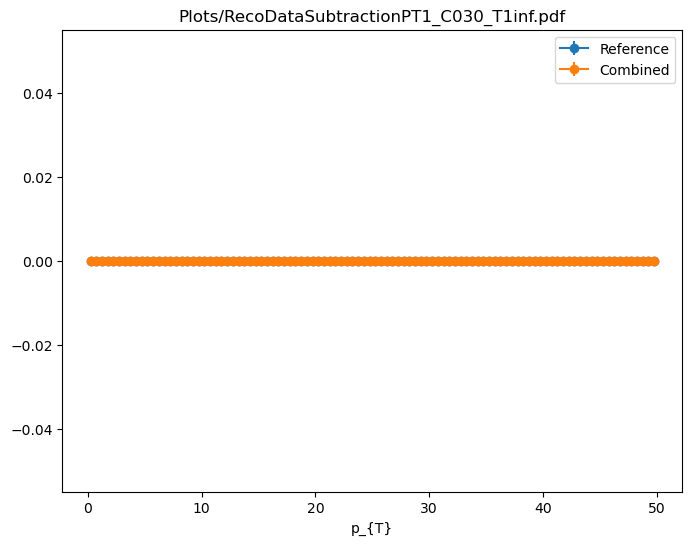

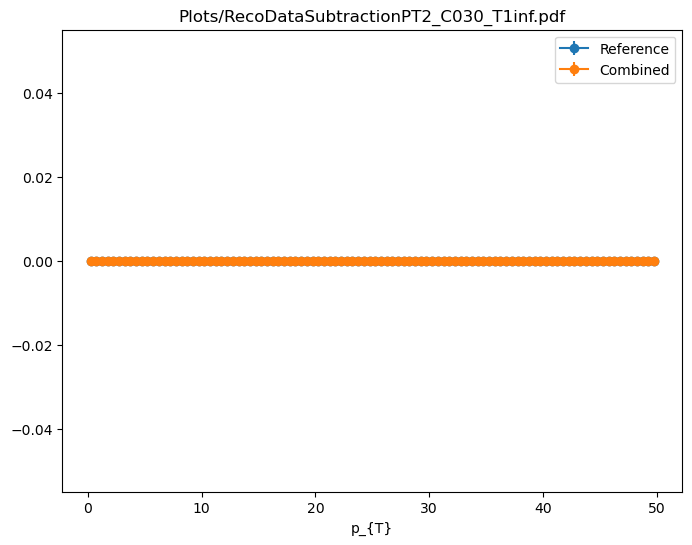

Warning in <TH1D::Add>: Histograms have different axis limits
Warning in <TH1D::Add>: Histograms have different axis limits
Warning in <TH1D::Add>: Histograms have different axis limits
Warning in <TH1D::Add>: Histograms have different axis limits


In [12]:
for P in ["DeltaREEC", "Phi", "Eta", "PT1", "PT2"]:
    MakeQuickPlot(f"Plots/RecoDataSubtraction{P}_C030_T1inf.pdf",
        ["PPDataxPPData_Reco.root",
           "PPMCxPPMC_Reco.root",
           "PbPbDataxPbPbData_Centrality030_Reco.root",
           "PbPbDataxMinBiasData_Centrality030_Reco.root",
           "MinBiasDataxMinBiasData_Centrality030_Reco.root",
           "MinBiasDataxMinBiasData_Centrality030_Reco_Different.root"],
        f"H{P}",
        [1, 0, 0, 0, 0, 0],
        [0, 0, 1, -2, -1, 2],
        1)
